<a href="https://colab.research.google.com/github/dvncrtr/AIML_Bootcamp_08222/blob/main/Fashion_MNIST_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Competition!
**Author**: W. Tod Newman

**Updates**: New Version

## Problem

Classify images from the "Fashion MNIST" data set.   Optimize the test accuracy.

## Metrics

This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:![alt text](https://user-images.githubusercontent.com/26015273/41822460-2ca0a90a-77f0-11e8-9c71-7e88fa6b5c61.gif)


The double sum is over the observations `i`, whose number is `N`, and the categories `c`, whose number is `C`. The term `1_{y_i \in C_c}` is the indicator function of the `i`th observation belonging to the `c`th category. The `p_{model}[y_i \in C_c]` is the probability predicted by the model for the `i`th observation to belong to the `c`th category. When there are more than two categories, the neural network outputs a vector of `C` probabilities, each giving the probability that the network input should be classified as belonging to the respective category. When the number of categories is just two, the neural network outputs a single probability `\hat{y}_i`, with the other one being `1` minus the output. This is why the binary cross entropy looks a bit different from categorical cross entropy, despite being a special case of it.

## Dataset

This dataset is the Fashion MNIST dataset

Recently, the researchers at Zalando, an e-commerce company, introduced Fashion MNIST as a drop-in replacement for the original MNIST dataset. Like MNIST, Fashion MNIST consists of a training set consisting of 60,000 examples belonging to 10 different classes and a test set of 10,000 examples. Each training example is a gray-scale image, 28x28 in size. The authors of the work further claim that the Fashion MNIST should actually replace MNIST dataset for benchmarking of new Machine Learning or Computer Vision models.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

The Labels are:  
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot 

## Objective

In this competition, you can try different variations of the CNN model given as a reference, you may evaluate techniques to squeeze more performance out of a CNN, or you might even try a completely different model, neural network or otherwise.  You will note that there are tips/tricks/techniques documented in many locations on the internet that could be useful.

## Rules and Timeline

The primary measure for the competition will be the accuracy of prediction on the test data.  Ties will be broken by Precision accuracy first, then Recall Accuracy if needed.

The results will be revealed at the end of the last day of class.  Please submit your Metrics blocks (Starts with SUBMIT... and ends with END SUBMISSION) to instructors (wtnewman@raytheon.com) before lunch.

A prize will be given to the top finisher(s) based on the judgement of the instructor and the availability of prizes.


In [41]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,  ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

## Set Up Variables

In [66]:
epochs = 400                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 700            # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

## Gather and Process Fashion MNIST data

1. First, collect the data from Keras (our goal is someday that our organizational data is this easy to get!)
2. Then split into train and test sets.
3. Next we need to process the data into the proper shape for the CNN
4. Then scale the floats to land between 0 and 1.  Often times we use sklearn's MinMaxScaler for this, but in this case we're going for simplicity.
5. Next take the y_train and y_test labels and encode them one-hot.  This will enable the CNN to function.

In [67]:
# Grab the data from the keras repository

mnist_data = fashion_mnist.load_data()
x = mnist_data[0][0]
y = mnist_data[0][1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=41)

# Process the date into the right tensor shape.  This is a good practice, but
# usually tensorflow uses channels last (the 'else' here)

if K.image_data_format() == "channels first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
#
#  Cast to a 32 bit float and then scale so the value is a float between 0 and 1
    
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

#
# Convert Class Vector to Binary Class Matrices (one-hot encoding).
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

#
# Function to decode one-hot encoding later on when we want to evaluate performance.
def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis=None, out=None) for yi in y]
    return y_classes

'''

Below we're experimenting with the Keras ImageDataGenerator.  From my experience, if these parameters
are set too aggressively, the loss/accuracy will either never improve or it will take too long to improve.
Below is an example of a complex data augmentation regime.  This is just for reference.  See my more simple
one at the bottom.

    
datagen = ImageDataGenerator(rotation_range=0.5, 
                                 zoom_range=0.1,
                                 featurewise_center=True,
                                 #featurewise_std_normalization=True,
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 shear_range=0.1,
                                 horizontal_flip=True, 
                                 fill_mode="nearest")
'''
#
#  Set up our Image Augmentation Data Generator
#
#datagen = ImageDataGenerator(rotation_range=5)
#datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')
datagen.fit(x_train)

(19800, 10)


## Build the Model

* In this example, we define the below block as a Sequential Model. 
* See the excellent [Keras Documentation](https://keras.io/guides/sequential_model/) on Sequential Models for info.
* Many of these parameters can be experimented with.  The documentation will help you understand how much to experiment.

In [68]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#
model = Sequential()

model.add(Conv2D(128, kernel_size=(5,5), input_shape=input_shape))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))  
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]


## Fit and Evaluate the Model

In [69]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = True

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adadelta(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
# fits the model on batches with real-time data augmentation:
    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 2)


score = model.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score[0])
print("Testing Accuracy:", score[1])
print("END SUBMISSION BLOCK\n")

model.summary()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/400
58/57 [==============================] - ETA: 0s - loss: 2.3117 - accuracy: 0.0984 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 23s 379ms/step - loss: 2.3117 - accuracy: 0.0984 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.3021 - val_accuracy: 0.1069 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 2/400
58/57 [==============================] - ETA: 0s - loss: 2.3052 - accuracy: 0.1046 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 383ms/step - loss: 2.3052 - accuracy: 0.1046 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2977 - val_accuracy: 0.1060 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 3/400
58/57 [==============================] - ETA: 0s - loss: 2.3004 - accuracy: 0.1094 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 372ms/step - loss: 2.3004 - accuracy: 0.1094 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2934 - val_accuracy: 0.1144 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 4/400
58/57 [==============================] - ETA: 0s - loss: 2.2962 - accuracy: 0.1144 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 374ms/step - loss: 2.2962 - accuracy: 0.1144 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2891 - val_accuracy: 0.1187 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 5/400
58/57 [==============================] - ETA: 0s - loss: 2.2932 - accuracy: 0.1161 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 380ms/step - loss: 2.2932 - accuracy: 0.1161 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2848 - val_accuracy: 0.1167 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 6/400
58/57 [==============================] - ETA: 0s - loss: 2.2885 - accuracy: 0.1178 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 362ms/step - loss: 2.2885 - accuracy: 0.1178 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2804 - val_accuracy: 0.1147 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 7/400
58/57 [==============================] - ETA: 0s - loss: 2.2860 - accuracy: 0.1199 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 23s 382ms/step - loss: 2.2860 - accuracy: 0.1199 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2761 - val_accuracy: 0.1147 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 8/400
58/57 [==============================] - ETA: 0s - loss: 2.2816 - accuracy: 0.1239 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 372ms/step - loss: 2.2816 - accuracy: 0.1239 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2717 - val_accuracy: 0.1141 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 9/400
58/57 [==============================] - ETA: 0s - loss: 2.2785 - accuracy: 0.1229 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 370ms/step - loss: 2.2785 - accuracy: 0.1229 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2671 - val_accuracy: 0.1153 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 10/400
58/57 [==============================] - ETA: 0s - loss: 2.2756 - accuracy: 0.1272 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 362ms/step - loss: 2.2756 - accuracy: 0.1272 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2624 - val_accuracy: 0.1176 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 11/400
58/57 [==============================] - ETA: 0s - loss: 2.2708 - accuracy: 0.1316 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 367ms/step - loss: 2.2708 - accuracy: 0.1316 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2575 - val_accuracy: 0.1215 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 12/400
58/57 [==============================] - ETA: 0s - loss: 2.2666 - accuracy: 0.1349 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 366ms/step - loss: 2.2666 - accuracy: 0.1349 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2524 - val_accuracy: 0.1262 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 13/400
57/57 [============================>.] - ETA: 0s - loss: 2.2646 - accuracy: 0.1359 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 368ms/step - loss: 2.2645 - accuracy: 0.1359 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2472 - val_accuracy: 0.1332 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 14/400
58/57 [==============================] - ETA: 0s - loss: 2.2603 - accuracy: 0.1406 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 367ms/step - loss: 2.2603 - accuracy: 0.1406 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2417 - val_accuracy: 0.1438 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 15/400
57/57 [============================>.] - ETA: 0s - loss: 2.2562 - accuracy: 0.1438 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 377ms/step - loss: 2.2562 - accuracy: 0.1436 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2361 - val_accuracy: 0.1548 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 16/400
58/57 [==============================] - ETA: 0s - loss: 2.2526 - accuracy: 0.1463 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 372ms/step - loss: 2.2526 - accuracy: 0.1463 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2303 - val_accuracy: 0.1684 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 17/400
58/57 [==============================] - ETA: 0s - loss: 2.2473 - accuracy: 0.1525 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 378ms/step - loss: 2.2473 - accuracy: 0.1525 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2242 - val_accuracy: 0.1861 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 18/400
58/57 [==============================] - ETA: 0s - loss: 2.2432 - accuracy: 0.1525 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 377ms/step - loss: 2.2432 - accuracy: 0.1525 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2177 - val_accuracy: 0.2011 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 19/400
58/57 [==============================] - ETA: 0s - loss: 2.2387 - accuracy: 0.1594 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 374ms/step - loss: 2.2387 - accuracy: 0.1594 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2109 - val_accuracy: 0.2170 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 20/400
58/57 [==============================] - ETA: 0s - loss: 2.2352 - accuracy: 0.1599 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 369ms/step - loss: 2.2352 - accuracy: 0.1599 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.2039 - val_accuracy: 0.2312 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 21/400
58/57 [==============================] - ETA: 0s - loss: 2.2297 - accuracy: 0.1649 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 377ms/step - loss: 2.2297 - accuracy: 0.1649 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.1963 - val_accuracy: 0.2432 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 22/400
58/57 [==============================] - ETA: 0s - loss: 2.2269 - accuracy: 0.1645 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 356ms/step - loss: 2.2269 - accuracy: 0.1645 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.1886 - val_accuracy: 0.2543 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 23/400
58/57 [==============================] - ETA: 0s - loss: 2.2196 - accuracy: 0.1713 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 353ms/step - loss: 2.2196 - accuracy: 0.1713 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.1803 - val_accuracy: 0.2652 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 24/400
58/57 [==============================] - ETA: 0s - loss: 2.2136 - accuracy: 0.1790 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 358ms/step - loss: 2.2136 - accuracy: 0.1790 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.1716 - val_accuracy: 0.2752 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 25/400
58/57 [==============================] - ETA: 0s - loss: 2.2087 - accuracy: 0.1777 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 359ms/step - loss: 2.2087 - accuracy: 0.1777 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.1627 - val_accuracy: 0.2844 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 26/400
58/57 [==============================] - ETA: 0s - loss: 2.2032 - accuracy: 0.1799 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 352ms/step - loss: 2.2032 - accuracy: 0.1799 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.1536 - val_accuracy: 0.2966 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 27/400
58/57 [==============================] - ETA: 0s - loss: 2.1948 - accuracy: 0.1896 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 356ms/step - loss: 2.1948 - accuracy: 0.1896 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.1438 - val_accuracy: 0.3137 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 28/400
58/57 [==============================] - ETA: 0s - loss: 2.1904 - accuracy: 0.1916 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 360ms/step - loss: 2.1904 - accuracy: 0.1916 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.1339 - val_accuracy: 0.3293 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 29/400
58/57 [==============================] - ETA: 0s - loss: 2.1851 - accuracy: 0.1911 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 21s 354ms/step - loss: 2.1851 - accuracy: 0.1911 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.1237 - val_accuracy: 0.3471 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 30/400
58/57 [==============================] - ETA: 0s - loss: 2.1775 - accuracy: 0.2007 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 380ms/step - loss: 2.1775 - accuracy: 0.2007 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.1129 - val_accuracy: 0.3623 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 31/400
58/57 [==============================] - ETA: 0s - loss: 2.1686 - accuracy: 0.2025 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 371ms/step - loss: 2.1686 - accuracy: 0.2025 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.1016 - val_accuracy: 0.3753 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 32/400
58/57 [==============================] - ETA: 0s - loss: 2.1654 - accuracy: 0.2040 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 371ms/step - loss: 2.1654 - accuracy: 0.2040 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.0904 - val_accuracy: 0.3846 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 33/400
58/57 [==============================] - ETA: 0s - loss: 2.1561 - accuracy: 0.2127 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 366ms/step - loss: 2.1561 - accuracy: 0.2127 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.0785 - val_accuracy: 0.3894 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 34/400
58/57 [==============================] - ETA: 0s - loss: 2.1511 - accuracy: 0.2082 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 369ms/step - loss: 2.1511 - accuracy: 0.2082 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.0663 - val_accuracy: 0.3965 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 35/400
58/57 [==============================] - ETA: 0s - loss: 2.1446 - accuracy: 0.2124 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 376ms/step - loss: 2.1446 - accuracy: 0.2124 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.0543 - val_accuracy: 0.4037 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 36/400
58/57 [==============================] - ETA: 0s - loss: 2.1371 - accuracy: 0.2178 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 367ms/step - loss: 2.1371 - accuracy: 0.2178 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.0419 - val_accuracy: 0.4094 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 37/400
58/57 [==============================] - ETA: 0s - loss: 2.1271 - accuracy: 0.2221 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 376ms/step - loss: 2.1271 - accuracy: 0.2221 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.0289 - val_accuracy: 0.4180 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 38/400
58/57 [==============================] - ETA: 0s - loss: 2.1213 - accuracy: 0.2231 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 385ms/step - loss: 2.1213 - accuracy: 0.2231 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.0161 - val_accuracy: 0.4272 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 39/400
58/57 [==============================] - ETA: 0s - loss: 2.1128 - accuracy: 0.2273 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00

57/57 [==============================] - 22s 375ms/step - loss: 2.1128 - accuracy: 0.2273 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 2.0037 - val_accuracy: 0.4376 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 40/400
58/57 [==============================] - ETA: 0s - loss: 2.1051 - accuracy: 0.2300 - precision_11: 0.6667 - recall_11: 4.9751e-05

57/57 [==============================] - 22s 374ms/step - loss: 2.1051 - accuracy: 0.2300 - precision_11: 0.6667 - recall_11: 4.9751e-05 - val_loss: 1.9907 - val_accuracy: 0.4530 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 41/400
58/57 [==============================] - ETA: 0s - loss: 2.0992 - accuracy: 0.2340 - precision_11: 0.5714 - recall_11: 9.9502e-05

57/57 [==============================] - 22s 373ms/step - loss: 2.0992 - accuracy: 0.2340 - precision_11: 0.5714 - recall_11: 9.9502e-05 - val_loss: 1.9780 - val_accuracy: 0.4660 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 42/400
58/57 [==============================] - ETA: 0s - loss: 2.0905 - accuracy: 0.2384 - precision_11: 0.5000 - recall_11: 9.9502e-05

57/57 [==============================] - 22s 382ms/step - loss: 2.0905 - accuracy: 0.2384 - precision_11: 0.5000 - recall_11: 9.9502e-05 - val_loss: 1.9653 - val_accuracy: 0.4779 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 43/400
58/57 [==============================] - ETA: 0s - loss: 2.0863 - accuracy: 0.2378 - precision_11: 0.5000 - recall_11: 1.2438e-04

57/57 [==============================] - 21s 366ms/step - loss: 2.0863 - accuracy: 0.2378 - precision_11: 0.5000 - recall_11: 1.2438e-04 - val_loss: 1.9528 - val_accuracy: 0.4839 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 44/400
58/57 [==============================] - ETA: 0s - loss: 2.0789 - accuracy: 0.2386 - precision_11: 0.6000 - recall_11: 2.9851e-04

57/57 [==============================] - 21s 366ms/step - loss: 2.0789 - accuracy: 0.2386 - precision_11: 0.6000 - recall_11: 2.9851e-04 - val_loss: 1.9407 - val_accuracy: 0.4893 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 45/400
58/57 [==============================] - ETA: 0s - loss: 2.0702 - accuracy: 0.2462 - precision_11: 0.4615 - recall_11: 1.4925e-04

57/57 [==============================] - 21s 362ms/step - loss: 2.0702 - accuracy: 0.2462 - precision_11: 0.4615 - recall_11: 1.4925e-04 - val_loss: 1.9282 - val_accuracy: 0.4956 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 46/400
58/57 [==============================] - ETA: 0s - loss: 2.0632 - accuracy: 0.2463 - precision_11: 0.5000 - recall_11: 2.7363e-04

57/57 [==============================] - 21s 369ms/step - loss: 2.0632 - accuracy: 0.2463 - precision_11: 0.5000 - recall_11: 2.7363e-04 - val_loss: 1.9157 - val_accuracy: 0.5015 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 47/400
58/57 [==============================] - ETA: 0s - loss: 2.0559 - accuracy: 0.2520 - precision_11: 0.6053 - recall_11: 5.7214e-04

57/57 [==============================] - 22s 372ms/step - loss: 2.0559 - accuracy: 0.2520 - precision_11: 0.6053 - recall_11: 5.7214e-04 - val_loss: 1.9030 - val_accuracy: 0.5118 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 48/400
58/57 [==============================] - ETA: 0s - loss: 2.0508 - accuracy: 0.2519 - precision_11: 0.6735 - recall_11: 8.2090e-04

57/57 [==============================] - 23s 392ms/step - loss: 2.0508 - accuracy: 0.2519 - precision_11: 0.6735 - recall_11: 8.2090e-04 - val_loss: 1.8908 - val_accuracy: 0.5198 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 49/400
58/57 [==============================] - ETA: 0s - loss: 2.0442 - accuracy: 0.2531 - precision_11: 0.6275 - recall_11: 7.9602e-04

57/57 [==============================] - 21s 370ms/step - loss: 2.0442 - accuracy: 0.2531 - precision_11: 0.6275 - recall_11: 7.9602e-04 - val_loss: 1.8787 - val_accuracy: 0.5261 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 50/400
58/57 [==============================] - ETA: 0s - loss: 2.0299 - accuracy: 0.2625 - precision_11: 0.6750 - recall_11: 0.0013

57/57 [==============================] - 23s 381ms/step - loss: 2.0299 - accuracy: 0.2625 - precision_11: 0.6750 - recall_11: 0.0013 - val_loss: 1.8659 - val_accuracy: 0.5324 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 51/400
58/57 [==============================] - ETA: 0s - loss: 2.0292 - accuracy: 0.2628 - precision_11: 0.6667 - recall_11: 0.0015

57/57 [==============================] - 22s 376ms/step - loss: 2.0292 - accuracy: 0.2628 - precision_11: 0.6667 - recall_11: 0.0015 - val_loss: 1.8539 - val_accuracy: 0.5365 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 52/400
58/57 [==============================] - ETA: 0s - loss: 2.0220 - accuracy: 0.2603 - precision_11: 0.6757 - recall_11: 0.0019

57/57 [==============================] - 22s 380ms/step - loss: 2.0220 - accuracy: 0.2603 - precision_11: 0.6757 - recall_11: 0.0019 - val_loss: 1.8421 - val_accuracy: 0.5419 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 53/400
58/57 [==============================] - ETA: 0s - loss: 2.0135 - accuracy: 0.2656 - precision_11: 0.6393 - recall_11: 0.0019

57/57 [==============================] - 22s 374ms/step - loss: 2.0135 - accuracy: 0.2656 - precision_11: 0.6393 - recall_11: 0.0019 - val_loss: 1.8299 - val_accuracy: 0.5454 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 54/400
57/57 [============================>.] - ETA: 0s - loss: 2.0093 - accuracy: 0.2665 - precision_11: 0.6433 - recall_11: 0.0026

57/57 [==============================] - 22s 382ms/step - loss: 2.0092 - accuracy: 0.2666 - precision_11: 0.6456 - recall_11: 0.0025 - val_loss: 1.8181 - val_accuracy: 0.5491 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 55/400
58/57 [==============================] - ETA: 0s - loss: 1.9982 - accuracy: 0.2739 - precision_11: 0.6432 - recall_11: 0.0032

57/57 [==============================] - 22s 383ms/step - loss: 1.9982 - accuracy: 0.2739 - precision_11: 0.6432 - recall_11: 0.0032 - val_loss: 1.8059 - val_accuracy: 0.5544 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 56/400
58/57 [==============================] - ETA: 0s - loss: 1.9932 - accuracy: 0.2758 - precision_11: 0.6696 - recall_11: 0.0038

57/57 [==============================] - 22s 371ms/step - loss: 1.9932 - accuracy: 0.2758 - precision_11: 0.6696 - recall_11: 0.0038 - val_loss: 1.7938 - val_accuracy: 0.5582 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 57/400
58/57 [==============================] - ETA: 0s - loss: 1.9836 - accuracy: 0.2750 - precision_11: 0.6562 - recall_11: 0.0042

57/57 [==============================] - 22s 374ms/step - loss: 1.9836 - accuracy: 0.2750 - precision_11: 0.6562 - recall_11: 0.0042 - val_loss: 1.7818 - val_accuracy: 0.5624 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 58/400
58/57 [==============================] - ETA: 0s - loss: 1.9789 - accuracy: 0.2804 - precision_11: 0.6769 - recall_11: 0.0044

57/57 [==============================] - 22s 377ms/step - loss: 1.9789 - accuracy: 0.2804 - precision_11: 0.6769 - recall_11: 0.0044 - val_loss: 1.7702 - val_accuracy: 0.5671 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 59/400
58/57 [==============================] - ETA: 0s - loss: 1.9722 - accuracy: 0.2856 - precision_11: 0.6440 - recall_11: 0.0052

57/57 [==============================] - 22s 374ms/step - loss: 1.9722 - accuracy: 0.2856 - precision_11: 0.6440 - recall_11: 0.0052 - val_loss: 1.7587 - val_accuracy: 0.5717 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 60/400
58/57 [==============================] - ETA: 0s - loss: 1.9678 - accuracy: 0.2885 - precision_11: 0.6375 - recall_11: 0.0063

57/57 [==============================] - 22s 371ms/step - loss: 1.9678 - accuracy: 0.2885 - precision_11: 0.6375 - recall_11: 0.0063 - val_loss: 1.7481 - val_accuracy: 0.5746 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 61/400
58/57 [==============================] - ETA: 0s - loss: 1.9564 - accuracy: 0.2877 - precision_11: 0.7133 - recall_11: 0.0075

57/57 [==============================] - 23s 383ms/step - loss: 1.9564 - accuracy: 0.2877 - precision_11: 0.7133 - recall_11: 0.0075 - val_loss: 1.7361 - val_accuracy: 0.5798 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 62/400
58/57 [==============================] - ETA: 0s - loss: 1.9552 - accuracy: 0.2907 - precision_11: 0.6454 - recall_11: 0.0076

57/57 [==============================] - 22s 370ms/step - loss: 1.9552 - accuracy: 0.2907 - precision_11: 0.6454 - recall_11: 0.0076 - val_loss: 1.7248 - val_accuracy: 0.5823 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 63/400
57/57 [============================>.] - ETA: 0s - loss: 1.9479 - accuracy: 0.2936 - precision_11: 0.6560 - recall_11: 0.0088

57/57 [==============================] - 21s 368ms/step - loss: 1.9481 - accuracy: 0.2936 - precision_11: 0.6561 - recall_11: 0.0087 - val_loss: 1.7135 - val_accuracy: 0.5859 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 64/400
58/57 [==============================] - ETA: 0s - loss: 1.9383 - accuracy: 0.2969 - precision_11: 0.6587 - recall_11: 0.0096

57/57 [==============================] - 23s 385ms/step - loss: 1.9383 - accuracy: 0.2969 - precision_11: 0.6587 - recall_11: 0.0096 - val_loss: 1.7019 - val_accuracy: 0.5889 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 65/400
58/57 [==============================] - ETA: 0s - loss: 1.9348 - accuracy: 0.2949 - precision_11: 0.6945 - recall_11: 0.0110

57/57 [==============================] - 22s 374ms/step - loss: 1.9348 - accuracy: 0.2949 - precision_11: 0.6945 - recall_11: 0.0110 - val_loss: 1.6914 - val_accuracy: 0.5911 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 66/400
58/57 [==============================] - ETA: 0s - loss: 1.9303 - accuracy: 0.2961 - precision_11: 0.6519 - recall_11: 0.0113

57/57 [==============================] - 22s 371ms/step - loss: 1.9303 - accuracy: 0.2961 - precision_11: 0.6519 - recall_11: 0.0113 - val_loss: 1.6811 - val_accuracy: 0.5936 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 67/400
57/57 [============================>.] - ETA: 0s - loss: 1.9258 - accuracy: 0.2964 - precision_11: 0.6372 - recall_11: 0.0119

57/57 [==============================] - 22s 378ms/step - loss: 1.9261 - accuracy: 0.2962 - precision_11: 0.6402 - recall_11: 0.0118 - val_loss: 1.6709 - val_accuracy: 0.5955 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 68/400
58/57 [==============================] - ETA: 0s - loss: 1.9178 - accuracy: 0.3015 - precision_11: 0.7000 - recall_11: 0.0151

57/57 [==============================] - 22s 375ms/step - loss: 1.9178 - accuracy: 0.3015 - precision_11: 0.7000 - recall_11: 0.0151 - val_loss: 1.6615 - val_accuracy: 0.5969 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 69/400
58/57 [==============================] - ETA: 0s - loss: 1.9128 - accuracy: 0.3036 - precision_11: 0.6495 - recall_11: 0.0138

57/57 [==============================] - 22s 383ms/step - loss: 1.9128 - accuracy: 0.3036 - precision_11: 0.6495 - recall_11: 0.0138 - val_loss: 1.6519 - val_accuracy: 0.5994 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 70/400
58/57 [==============================] - ETA: 0s - loss: 1.9116 - accuracy: 0.3040 - precision_11: 0.6744 - recall_11: 0.0165

57/57 [==============================] - 22s 371ms/step - loss: 1.9116 - accuracy: 0.3040 - precision_11: 0.6744 - recall_11: 0.0165 - val_loss: 1.6426 - val_accuracy: 0.6009 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 71/400
58/57 [==============================] - ETA: 0s - loss: 1.9022 - accuracy: 0.3071 - precision_11: 0.6508 - recall_11: 0.0167

57/57 [==============================] - 22s 369ms/step - loss: 1.9022 - accuracy: 0.3071 - precision_11: 0.6508 - recall_11: 0.0167 - val_loss: 1.6337 - val_accuracy: 0.6033 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 72/400
57/57 [============================>.] - ETA: 0s - loss: 1.9017 - accuracy: 0.3067 - precision_11: 0.6702 - recall_11: 0.0192

57/57 [==============================] - 22s 371ms/step - loss: 1.9015 - accuracy: 0.3069 - precision_11: 0.6696 - recall_11: 0.0192 - val_loss: 1.6251 - val_accuracy: 0.6052 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 73/400
58/57 [==============================] - ETA: 0s - loss: 1.8892 - accuracy: 0.3132 - precision_11: 0.6343 - recall_11: 0.0180

57/57 [==============================] - 22s 372ms/step - loss: 1.8892 - accuracy: 0.3132 - precision_11: 0.6343 - recall_11: 0.0180 - val_loss: 1.6155 - val_accuracy: 0.6060 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 74/400
58/57 [==============================] - ETA: 0s - loss: 1.8896 - accuracy: 0.3105 - precision_11: 0.6468 - recall_11: 0.0208

57/57 [==============================] - 23s 388ms/step - loss: 1.8896 - accuracy: 0.3105 - precision_11: 0.6468 - recall_11: 0.0208 - val_loss: 1.6060 - val_accuracy: 0.6068 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 75/400
58/57 [==============================] - ETA: 0s - loss: 1.8840 - accuracy: 0.3155 - precision_11: 0.6402 - recall_11: 0.0209

57/57 [==============================] - 22s 374ms/step - loss: 1.8840 - accuracy: 0.3155 - precision_11: 0.6402 - recall_11: 0.0209 - val_loss: 1.5974 - val_accuracy: 0.6074 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 76/400
58/57 [==============================] - ETA: 0s - loss: 1.8760 - accuracy: 0.3168 - precision_11: 0.6531 - recall_11: 0.0231

57/57 [==============================] - 22s 375ms/step - loss: 1.8760 - accuracy: 0.3168 - precision_11: 0.6531 - recall_11: 0.0231 - val_loss: 1.5887 - val_accuracy: 0.6097 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 77/400
58/57 [==============================] - ETA: 0s - loss: 1.8711 - accuracy: 0.3200 - precision_11: 0.6797 - recall_11: 0.0259

57/57 [==============================] - 22s 379ms/step - loss: 1.8711 - accuracy: 0.3200 - precision_11: 0.6797 - recall_11: 0.0259 - val_loss: 1.5804 - val_accuracy: 0.6101 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 78/400
58/57 [==============================] - ETA: 0s - loss: 1.8662 - accuracy: 0.3204 - precision_11: 0.6442 - recall_11: 0.0267

57/57 [==============================] - 22s 372ms/step - loss: 1.8662 - accuracy: 0.3204 - precision_11: 0.6442 - recall_11: 0.0267 - val_loss: 1.5719 - val_accuracy: 0.6102 - val_precision_11: 0.5000 - val_recall_11: 5.0505e-05
Epoch 79/400
57/57 [============================>.] - ETA: 0s - loss: 1.8666 - accuracy: 0.3182 - precision_11: 0.6571 - recall_11: 0.0277

57/57 [==============================] - 22s 374ms/step - loss: 1.8662 - accuracy: 0.3186 - precision_11: 0.6559 - recall_11: 0.0278 - val_loss: 1.5642 - val_accuracy: 0.6115 - val_precision_11: 0.6000 - val_recall_11: 1.5152e-04
Epoch 80/400
57/57 [============================>.] - ETA: 0s - loss: 1.8662 - accuracy: 0.3221 - precision_11: 0.6413 - recall_11: 0.0282

57/57 [==============================] - 23s 385ms/step - loss: 1.8656 - accuracy: 0.3226 - precision_11: 0.6442 - recall_11: 0.0282 - val_loss: 1.5571 - val_accuracy: 0.6121 - val_precision_11: 0.6000 - val_recall_11: 1.5152e-04
Epoch 81/400
58/57 [==============================] - ETA: 0s - loss: 1.8526 - accuracy: 0.3250 - precision_11: 0.6544 - recall_11: 0.0309

57/57 [==============================] - 21s 369ms/step - loss: 1.8526 - accuracy: 0.3250 - precision_11: 0.6544 - recall_11: 0.0309 - val_loss: 1.5474 - val_accuracy: 0.6127 - val_precision_11: 0.6250 - val_recall_11: 2.5253e-04
Epoch 82/400
58/57 [==============================] - ETA: 0s - loss: 1.8544 - accuracy: 0.3255 - precision_11: 0.6601 - recall_11: 0.0335

57/57 [==============================] - 22s 372ms/step - loss: 1.8544 - accuracy: 0.3255 - precision_11: 0.6601 - recall_11: 0.0335 - val_loss: 1.5405 - val_accuracy: 0.6137 - val_precision_11: 0.7500 - val_recall_11: 4.5455e-04
Epoch 83/400
57/57 [============================>.] - ETA: 0s - loss: 1.8537 - accuracy: 0.3259 - precision_11: 0.6572 - recall_11: 0.0341

57/57 [==============================] - 22s 378ms/step - loss: 1.8530 - accuracy: 0.3261 - precision_11: 0.6584 - recall_11: 0.0342 - val_loss: 1.5335 - val_accuracy: 0.6135 - val_precision_11: 0.8125 - val_recall_11: 6.5657e-04
Epoch 84/400
58/57 [==============================] - ETA: 0s - loss: 1.8442 - accuracy: 0.3285 - precision_11: 0.6502 - recall_11: 0.0346

57/57 [==============================] - 22s 374ms/step - loss: 1.8442 - accuracy: 0.3285 - precision_11: 0.6502 - recall_11: 0.0346 - val_loss: 1.5253 - val_accuracy: 0.6139 - val_precision_11: 0.8571 - val_recall_11: 9.0909e-04
Epoch 85/400
58/57 [==============================] - ETA: 0s - loss: 1.8407 - accuracy: 0.3330 - precision_11: 0.6620 - recall_11: 0.0378

57/57 [==============================] - 22s 373ms/step - loss: 1.8407 - accuracy: 0.3330 - precision_11: 0.6620 - recall_11: 0.0378 - val_loss: 1.5188 - val_accuracy: 0.6143 - val_precision_11: 0.8966 - val_recall_11: 0.0013
Epoch 86/400
58/57 [==============================] - ETA: 0s - loss: 1.8340 - accuracy: 0.3382 - precision_11: 0.6568 - recall_11: 0.0399

57/57 [==============================] - 21s 367ms/step - loss: 1.8340 - accuracy: 0.3382 - precision_11: 0.6568 - recall_11: 0.0399 - val_loss: 1.5121 - val_accuracy: 0.6149 - val_precision_11: 0.9167 - val_recall_11: 0.0022
Epoch 87/400
58/57 [==============================] - ETA: 0s - loss: 1.8334 - accuracy: 0.3326 - precision_11: 0.6600 - recall_11: 0.0393

57/57 [==============================] - 22s 385ms/step - loss: 1.8334 - accuracy: 0.3326 - precision_11: 0.6600 - recall_11: 0.0393 - val_loss: 1.5054 - val_accuracy: 0.6145 - val_precision_11: 0.9275 - val_recall_11: 0.0032
Epoch 88/400
58/57 [==============================] - ETA: 0s - loss: 1.8255 - accuracy: 0.3371 - precision_11: 0.6417 - recall_11: 0.0401

57/57 [==============================] - 22s 381ms/step - loss: 1.8255 - accuracy: 0.3371 - precision_11: 0.6417 - recall_11: 0.0401 - val_loss: 1.4987 - val_accuracy: 0.6146 - val_precision_11: 0.9362 - val_recall_11: 0.0044
Epoch 89/400
57/57 [============================>.] - ETA: 0s - loss: 1.8231 - accuracy: 0.3388 - precision_11: 0.6557 - recall_11: 0.0443

57/57 [==============================] - 22s 375ms/step - loss: 1.8231 - accuracy: 0.3386 - precision_11: 0.6569 - recall_11: 0.0444 - val_loss: 1.4909 - val_accuracy: 0.6163 - val_precision_11: 0.9562 - val_recall_11: 0.0066
Epoch 90/400
57/57 [============================>.] - ETA: 0s - loss: 1.8232 - accuracy: 0.3367 - precision_11: 0.6358 - recall_11: 0.0451

57/57 [==============================] - 22s 375ms/step - loss: 1.8226 - accuracy: 0.3366 - precision_11: 0.6364 - recall_11: 0.0452 - val_loss: 1.4846 - val_accuracy: 0.6166 - val_precision_11: 0.9521 - val_recall_11: 0.0080
Epoch 91/400
58/57 [==============================] - ETA: 0s - loss: 1.8138 - accuracy: 0.3449 - precision_11: 0.6659 - recall_11: 0.0479

57/57 [==============================] - 22s 377ms/step - loss: 1.8138 - accuracy: 0.3449 - precision_11: 0.6659 - recall_11: 0.0479 - val_loss: 1.4777 - val_accuracy: 0.6167 - val_precision_11: 0.9591 - val_recall_11: 0.0107
Epoch 92/400
58/57 [==============================] - ETA: 0s - loss: 1.8098 - accuracy: 0.3441 - precision_11: 0.6537 - recall_11: 0.0482

57/57 [==============================] - 22s 371ms/step - loss: 1.8098 - accuracy: 0.3441 - precision_11: 0.6537 - recall_11: 0.0482 - val_loss: 1.4712 - val_accuracy: 0.6166 - val_precision_11: 0.9541 - val_recall_11: 0.0136
Epoch 93/400
57/57 [============================>.] - ETA: 0s - loss: 1.8112 - accuracy: 0.3426 - precision_11: 0.6395 - recall_11: 0.0490

57/57 [==============================] - 23s 386ms/step - loss: 1.8113 - accuracy: 0.3428 - precision_11: 0.6396 - recall_11: 0.0490 - val_loss: 1.4651 - val_accuracy: 0.6154 - val_precision_11: 0.9610 - val_recall_11: 0.0174
Epoch 94/400
58/57 [==============================] - ETA: 0s - loss: 1.8016 - accuracy: 0.3456 - precision_11: 0.6568 - recall_11: 0.0534

57/57 [==============================] - 22s 372ms/step - loss: 1.8016 - accuracy: 0.3456 - precision_11: 0.6568 - recall_11: 0.0534 - val_loss: 1.4584 - val_accuracy: 0.6162 - val_precision_11: 0.9610 - val_recall_11: 0.0212
Epoch 95/400
58/57 [==============================] - ETA: 0s - loss: 1.8008 - accuracy: 0.3434 - precision_11: 0.6545 - recall_11: 0.0535

57/57 [==============================] - 22s 372ms/step - loss: 1.8008 - accuracy: 0.3434 - precision_11: 0.6545 - recall_11: 0.0535 - val_loss: 1.4528 - val_accuracy: 0.6167 - val_precision_11: 0.9626 - val_recall_11: 0.0247
Epoch 96/400
58/57 [==============================] - ETA: 0s - loss: 1.7947 - accuracy: 0.3491 - precision_11: 0.6596 - recall_11: 0.0548

57/57 [==============================] - 22s 372ms/step - loss: 1.7947 - accuracy: 0.3491 - precision_11: 0.6596 - recall_11: 0.0548 - val_loss: 1.4467 - val_accuracy: 0.6165 - val_precision_11: 0.9649 - val_recall_11: 0.0277
Epoch 97/400
58/57 [==============================] - ETA: 0s - loss: 1.7951 - accuracy: 0.3486 - precision_11: 0.6510 - recall_11: 0.0553

57/57 [==============================] - 22s 373ms/step - loss: 1.7951 - accuracy: 0.3486 - precision_11: 0.6510 - recall_11: 0.0553 - val_loss: 1.4417 - val_accuracy: 0.6163 - val_precision_11: 0.9644 - val_recall_11: 0.0328
Epoch 98/400
58/57 [==============================] - ETA: 0s - loss: 1.7952 - accuracy: 0.3505 - precision_11: 0.6473 - recall_11: 0.0560

57/57 [==============================] - 22s 377ms/step - loss: 1.7952 - accuracy: 0.3505 - precision_11: 0.6473 - recall_11: 0.0560 - val_loss: 1.4370 - val_accuracy: 0.6169 - val_precision_11: 0.9664 - val_recall_11: 0.0363
Epoch 99/400
58/57 [==============================] - ETA: 0s - loss: 1.7864 - accuracy: 0.3494 - precision_11: 0.6721 - recall_11: 0.0600

57/57 [==============================] - 22s 383ms/step - loss: 1.7864 - accuracy: 0.3494 - precision_11: 0.6721 - recall_11: 0.0600 - val_loss: 1.4310 - val_accuracy: 0.6177 - val_precision_11: 0.9671 - val_recall_11: 0.0416
Epoch 100/400
58/57 [==============================] - ETA: 0s - loss: 1.7783 - accuracy: 0.3558 - precision_11: 0.6594 - recall_11: 0.0605

57/57 [==============================] - 22s 384ms/step - loss: 1.7783 - accuracy: 0.3558 - precision_11: 0.6594 - recall_11: 0.0605 - val_loss: 1.4258 - val_accuracy: 0.6174 - val_precision_11: 0.9699 - val_recall_11: 0.0472
Epoch 101/400
58/57 [==============================] - ETA: 0s - loss: 1.7792 - accuracy: 0.3540 - precision_11: 0.6617 - recall_11: 0.0631

57/57 [==============================] - 23s 387ms/step - loss: 1.7792 - accuracy: 0.3540 - precision_11: 0.6617 - recall_11: 0.0631 - val_loss: 1.4204 - val_accuracy: 0.6169 - val_precision_11: 0.9696 - val_recall_11: 0.0531
Epoch 102/400
58/57 [==============================] - ETA: 0s - loss: 1.7762 - accuracy: 0.3552 - precision_11: 0.6672 - recall_11: 0.0634

57/57 [==============================] - 22s 376ms/step - loss: 1.7762 - accuracy: 0.3552 - precision_11: 0.6672 - recall_11: 0.0634 - val_loss: 1.4148 - val_accuracy: 0.6169 - val_precision_11: 0.9697 - val_recall_11: 0.0581
Epoch 103/400
58/57 [==============================] - ETA: 0s - loss: 1.7717 - accuracy: 0.3573 - precision_11: 0.6539 - recall_11: 0.0649

57/57 [==============================] - 22s 374ms/step - loss: 1.7717 - accuracy: 0.3573 - precision_11: 0.6539 - recall_11: 0.0649 - val_loss: 1.4102 - val_accuracy: 0.6173 - val_precision_11: 0.9654 - val_recall_11: 0.0634
Epoch 104/400
58/57 [==============================] - ETA: 0s - loss: 1.7768 - accuracy: 0.3538 - precision_11: 0.6510 - recall_11: 0.0667

57/57 [==============================] - 22s 377ms/step - loss: 1.7768 - accuracy: 0.3538 - precision_11: 0.6510 - recall_11: 0.0667 - val_loss: 1.4062 - val_accuracy: 0.6177 - val_precision_11: 0.9629 - val_recall_11: 0.0694
Epoch 105/400
58/57 [==============================] - ETA: 0s - loss: 1.7654 - accuracy: 0.3572 - precision_11: 0.6658 - recall_11: 0.0677

57/57 [==============================] - 22s 376ms/step - loss: 1.7654 - accuracy: 0.3572 - precision_11: 0.6658 - recall_11: 0.0677 - val_loss: 1.4001 - val_accuracy: 0.6176 - val_precision_11: 0.9621 - val_recall_11: 0.0743
Epoch 106/400
58/57 [==============================] - ETA: 0s - loss: 1.7626 - accuracy: 0.3586 - precision_11: 0.6576 - recall_11: 0.0692

57/57 [==============================] - 24s 404ms/step - loss: 1.7626 - accuracy: 0.3586 - precision_11: 0.6576 - recall_11: 0.0692 - val_loss: 1.3945 - val_accuracy: 0.6185 - val_precision_11: 0.9585 - val_recall_11: 0.0806
Epoch 107/400
58/57 [==============================] - ETA: 0s - loss: 1.7617 - accuracy: 0.3592 - precision_11: 0.6456 - recall_11: 0.0713

57/57 [==============================] - 22s 384ms/step - loss: 1.7617 - accuracy: 0.3592 - precision_11: 0.6456 - recall_11: 0.0713 - val_loss: 1.3903 - val_accuracy: 0.6177 - val_precision_11: 0.9571 - val_recall_11: 0.0867
Epoch 108/400
58/57 [==============================] - ETA: 0s - loss: 1.7584 - accuracy: 0.3614 - precision_11: 0.6521 - recall_11: 0.0737

57/57 [==============================] - 22s 380ms/step - loss: 1.7584 - accuracy: 0.3614 - precision_11: 0.6521 - recall_11: 0.0737 - val_loss: 1.3856 - val_accuracy: 0.6182 - val_precision_11: 0.9562 - val_recall_11: 0.0937
Epoch 109/400
58/57 [==============================] - ETA: 0s - loss: 1.7537 - accuracy: 0.3651 - precision_11: 0.6577 - recall_11: 0.0740

57/57 [==============================] - 22s 378ms/step - loss: 1.7537 - accuracy: 0.3651 - precision_11: 0.6577 - recall_11: 0.0740 - val_loss: 1.3805 - val_accuracy: 0.6181 - val_precision_11: 0.9550 - val_recall_11: 0.0966
Epoch 110/400
58/57 [==============================] - ETA: 0s - loss: 1.7524 - accuracy: 0.3620 - precision_11: 0.6549 - recall_11: 0.0740

57/57 [==============================] - 22s 368ms/step - loss: 1.7524 - accuracy: 0.3620 - precision_11: 0.6549 - recall_11: 0.0740 - val_loss: 1.3757 - val_accuracy: 0.6203 - val_precision_11: 0.9542 - val_recall_11: 0.1031
Epoch 111/400
58/57 [==============================] - ETA: 0s - loss: 1.7520 - accuracy: 0.3662 - precision_11: 0.6442 - recall_11: 0.0743

57/57 [==============================] - 22s 372ms/step - loss: 1.7520 - accuracy: 0.3662 - precision_11: 0.6442 - recall_11: 0.0743 - val_loss: 1.3701 - val_accuracy: 0.6197 - val_precision_11: 0.9543 - val_recall_11: 0.1098
Epoch 112/400
58/57 [==============================] - ETA: 0s - loss: 1.7470 - accuracy: 0.3663 - precision_11: 0.6617 - recall_11: 0.0782

57/57 [==============================] - 22s 379ms/step - loss: 1.7470 - accuracy: 0.3663 - precision_11: 0.6617 - recall_11: 0.0782 - val_loss: 1.3661 - val_accuracy: 0.6190 - val_precision_11: 0.9542 - val_recall_11: 0.1158
Epoch 113/400
58/57 [==============================] - ETA: 0s - loss: 1.7400 - accuracy: 0.3673 - precision_11: 0.6681 - recall_11: 0.0828

57/57 [==============================] - 22s 373ms/step - loss: 1.7400 - accuracy: 0.3673 - precision_11: 0.6681 - recall_11: 0.0828 - val_loss: 1.3619 - val_accuracy: 0.6199 - val_precision_11: 0.9507 - val_recall_11: 0.1219
Epoch 114/400
58/57 [==============================] - ETA: 0s - loss: 1.7411 - accuracy: 0.3668 - precision_11: 0.6673 - recall_11: 0.0820

57/57 [==============================] - 22s 384ms/step - loss: 1.7411 - accuracy: 0.3668 - precision_11: 0.6673 - recall_11: 0.0820 - val_loss: 1.3570 - val_accuracy: 0.6193 - val_precision_11: 0.9519 - val_recall_11: 0.1261
Epoch 115/400
58/57 [==============================] - ETA: 0s - loss: 1.7446 - accuracy: 0.3669 - precision_11: 0.6480 - recall_11: 0.0810

57/57 [==============================] - 22s 384ms/step - loss: 1.7446 - accuracy: 0.3669 - precision_11: 0.6480 - recall_11: 0.0810 - val_loss: 1.3552 - val_accuracy: 0.6192 - val_precision_11: 0.9497 - val_recall_11: 0.1305
Epoch 116/400
57/57 [============================>.] - ETA: 0s - loss: 1.7358 - accuracy: 0.3670 - precision_11: 0.6591 - recall_11: 0.0816

57/57 [==============================] - 21s 368ms/step - loss: 1.7366 - accuracy: 0.3669 - precision_11: 0.6564 - recall_11: 0.0815 - val_loss: 1.3507 - val_accuracy: 0.6185 - val_precision_11: 0.9475 - val_recall_11: 0.1348
Epoch 117/400
58/57 [==============================] - ETA: 0s - loss: 1.7338 - accuracy: 0.3696 - precision_11: 0.6487 - recall_11: 0.0835

57/57 [==============================] - 22s 375ms/step - loss: 1.7338 - accuracy: 0.3696 - precision_11: 0.6487 - recall_11: 0.0835 - val_loss: 1.3458 - val_accuracy: 0.6202 - val_precision_11: 0.9464 - val_recall_11: 0.1410
Epoch 118/400
58/57 [==============================] - ETA: 0s - loss: 1.7247 - accuracy: 0.3751 - precision_11: 0.6635 - recall_11: 0.0876

57/57 [==============================] - 22s 378ms/step - loss: 1.7247 - accuracy: 0.3751 - precision_11: 0.6635 - recall_11: 0.0876 - val_loss: 1.3406 - val_accuracy: 0.6209 - val_precision_11: 0.9453 - val_recall_11: 0.1465
Epoch 119/400
58/57 [==============================] - ETA: 0s - loss: 1.7268 - accuracy: 0.3715 - precision_11: 0.6445 - recall_11: 0.0854

57/57 [==============================] - 22s 372ms/step - loss: 1.7268 - accuracy: 0.3715 - precision_11: 0.6445 - recall_11: 0.0854 - val_loss: 1.3378 - val_accuracy: 0.6199 - val_precision_11: 0.9422 - val_recall_11: 0.1516
Epoch 120/400
58/57 [==============================] - ETA: 0s - loss: 1.7241 - accuracy: 0.3758 - precision_11: 0.6582 - recall_11: 0.0880

57/57 [==============================] - 22s 372ms/step - loss: 1.7241 - accuracy: 0.3758 - precision_11: 0.6582 - recall_11: 0.0880 - val_loss: 1.3343 - val_accuracy: 0.6198 - val_precision_11: 0.9412 - val_recall_11: 0.1529
Epoch 121/400
58/57 [==============================] - ETA: 0s - loss: 1.7180 - accuracy: 0.3773 - precision_11: 0.6534 - recall_11: 0.0920

57/57 [==============================] - 22s 383ms/step - loss: 1.7180 - accuracy: 0.3773 - precision_11: 0.6534 - recall_11: 0.0920 - val_loss: 1.3297 - val_accuracy: 0.6204 - val_precision_11: 0.9414 - val_recall_11: 0.1581
Epoch 122/400
58/57 [==============================] - ETA: 0s - loss: 1.7178 - accuracy: 0.3787 - precision_11: 0.6552 - recall_11: 0.0913

57/57 [==============================] - 22s 369ms/step - loss: 1.7178 - accuracy: 0.3787 - precision_11: 0.6552 - recall_11: 0.0913 - val_loss: 1.3266 - val_accuracy: 0.6191 - val_precision_11: 0.9411 - val_recall_11: 0.1639
Epoch 123/400
58/57 [==============================] - ETA: 0s - loss: 1.7208 - accuracy: 0.3726 - precision_11: 0.6566 - recall_11: 0.0921

57/57 [==============================] - 22s 383ms/step - loss: 1.7208 - accuracy: 0.3726 - precision_11: 0.6566 - recall_11: 0.0921 - val_loss: 1.3228 - val_accuracy: 0.6207 - val_precision_11: 0.9416 - val_recall_11: 0.1671
Epoch 124/400
58/57 [==============================] - ETA: 0s - loss: 1.7134 - accuracy: 0.3808 - precision_11: 0.6590 - recall_11: 0.0925

57/57 [==============================] - 22s 379ms/step - loss: 1.7134 - accuracy: 0.3808 - precision_11: 0.6590 - recall_11: 0.0925 - val_loss: 1.3188 - val_accuracy: 0.6215 - val_precision_11: 0.9388 - val_recall_11: 0.1713
Epoch 125/400
57/57 [============================>.] - ETA: 0s - loss: 1.7170 - accuracy: 0.3788 - precision_11: 0.6555 - recall_11: 0.0955

57/57 [==============================] - 22s 377ms/step - loss: 1.7170 - accuracy: 0.3791 - precision_11: 0.6548 - recall_11: 0.0956 - val_loss: 1.3162 - val_accuracy: 0.6217 - val_precision_11: 0.9387 - val_recall_11: 0.1718
Epoch 126/400
58/57 [==============================] - ETA: 0s - loss: 1.7060 - accuracy: 0.3843 - precision_11: 0.6577 - recall_11: 0.0961

57/57 [==============================] - 22s 372ms/step - loss: 1.7060 - accuracy: 0.3843 - precision_11: 0.6577 - recall_11: 0.0961 - val_loss: 1.3116 - val_accuracy: 0.6216 - val_precision_11: 0.9362 - val_recall_11: 0.1785
Epoch 127/400
57/57 [============================>.] - ETA: 0s - loss: 1.7013 - accuracy: 0.3798 - precision_11: 0.6595 - recall_11: 0.1000

57/57 [==============================] - 22s 381ms/step - loss: 1.7014 - accuracy: 0.3796 - precision_11: 0.6608 - recall_11: 0.1002 - val_loss: 1.3069 - val_accuracy: 0.6209 - val_precision_11: 0.9363 - val_recall_11: 0.1840
Epoch 128/400
58/57 [==============================] - ETA: 0s - loss: 1.7069 - accuracy: 0.3822 - precision_11: 0.6454 - recall_11: 0.0965

57/57 [==============================] - 22s 385ms/step - loss: 1.7069 - accuracy: 0.3822 - precision_11: 0.6454 - recall_11: 0.0965 - val_loss: 1.3043 - val_accuracy: 0.6216 - val_precision_11: 0.9333 - val_recall_11: 0.1879
Epoch 129/400
57/57 [============================>.] - ETA: 0s - loss: 1.7020 - accuracy: 0.3850 - precision_11: 0.6582 - recall_11: 0.1001

57/57 [==============================] - 21s 368ms/step - loss: 1.7018 - accuracy: 0.3849 - precision_11: 0.6580 - recall_11: 0.1000 - val_loss: 1.3012 - val_accuracy: 0.6204 - val_precision_11: 0.9338 - val_recall_11: 0.1918
Epoch 130/400
58/57 [==============================] - ETA: 0s - loss: 1.6956 - accuracy: 0.3851 - precision_11: 0.6569 - recall_11: 0.1037

57/57 [==============================] - 22s 372ms/step - loss: 1.6956 - accuracy: 0.3851 - precision_11: 0.6569 - recall_11: 0.1037 - val_loss: 1.2989 - val_accuracy: 0.6199 - val_precision_11: 0.9322 - val_recall_11: 0.1965
Epoch 131/400
58/57 [==============================] - ETA: 0s - loss: 1.6985 - accuracy: 0.3869 - precision_11: 0.6616 - recall_11: 0.1022

57/57 [==============================] - 22s 369ms/step - loss: 1.6985 - accuracy: 0.3869 - precision_11: 0.6616 - recall_11: 0.1022 - val_loss: 1.2956 - val_accuracy: 0.6198 - val_precision_11: 0.9316 - val_recall_11: 0.1987
Epoch 132/400
58/57 [==============================] - ETA: 0s - loss: 1.6936 - accuracy: 0.3833 - precision_11: 0.6569 - recall_11: 0.1039

57/57 [==============================] - 23s 382ms/step - loss: 1.6936 - accuracy: 0.3833 - precision_11: 0.6569 - recall_11: 0.1039 - val_loss: 1.2914 - val_accuracy: 0.6212 - val_precision_11: 0.9307 - val_recall_11: 0.2042
Epoch 133/400
58/57 [==============================] - ETA: 0s - loss: 1.6971 - accuracy: 0.3857 - precision_11: 0.6511 - recall_11: 0.1043

57/57 [==============================] - 23s 401ms/step - loss: 1.6971 - accuracy: 0.3857 - precision_11: 0.6511 - recall_11: 0.1043 - val_loss: 1.2893 - val_accuracy: 0.6204 - val_precision_11: 0.9286 - val_recall_11: 0.2083
Epoch 134/400
58/57 [==============================] - ETA: 0s - loss: 1.6888 - accuracy: 0.3902 - precision_11: 0.6582 - recall_11: 0.1057

57/57 [==============================] - 22s 382ms/step - loss: 1.6888 - accuracy: 0.3902 - precision_11: 0.6582 - recall_11: 0.1057 - val_loss: 1.2844 - val_accuracy: 0.6213 - val_precision_11: 0.9284 - val_recall_11: 0.2128
Epoch 135/400
58/57 [==============================] - ETA: 0s - loss: 1.6868 - accuracy: 0.3885 - precision_11: 0.6564 - recall_11: 0.1077

57/57 [==============================] - 22s 387ms/step - loss: 1.6868 - accuracy: 0.3885 - precision_11: 0.6564 - recall_11: 0.1077 - val_loss: 1.2813 - val_accuracy: 0.6220 - val_precision_11: 0.9269 - val_recall_11: 0.2132
Epoch 136/400
58/57 [==============================] - ETA: 0s - loss: 1.6845 - accuracy: 0.3907 - precision_11: 0.6557 - recall_11: 0.1086

57/57 [==============================] - 22s 376ms/step - loss: 1.6845 - accuracy: 0.3907 - precision_11: 0.6557 - recall_11: 0.1086 - val_loss: 1.2792 - val_accuracy: 0.6211 - val_precision_11: 0.9271 - val_recall_11: 0.2157
Epoch 137/400
58/57 [==============================] - ETA: 0s - loss: 1.6799 - accuracy: 0.3909 - precision_11: 0.6516 - recall_11: 0.1097

57/57 [==============================] - 22s 374ms/step - loss: 1.6799 - accuracy: 0.3909 - precision_11: 0.6516 - recall_11: 0.1097 - val_loss: 1.2761 - val_accuracy: 0.6202 - val_precision_11: 0.9254 - val_recall_11: 0.2200
Epoch 138/400
58/57 [==============================] - ETA: 0s - loss: 1.6769 - accuracy: 0.3935 - precision_11: 0.6592 - recall_11: 0.1140

57/57 [==============================] - 23s 399ms/step - loss: 1.6769 - accuracy: 0.3935 - precision_11: 0.6592 - recall_11: 0.1140 - val_loss: 1.2718 - val_accuracy: 0.6215 - val_precision_11: 0.9251 - val_recall_11: 0.2239
Epoch 139/400
58/57 [==============================] - ETA: 0s - loss: 1.6824 - accuracy: 0.3920 - precision_11: 0.6611 - recall_11: 0.1110

57/57 [==============================] - 22s 374ms/step - loss: 1.6824 - accuracy: 0.3920 - precision_11: 0.6611 - recall_11: 0.1110 - val_loss: 1.2702 - val_accuracy: 0.6210 - val_precision_11: 0.9233 - val_recall_11: 0.2269
Epoch 140/400
58/57 [==============================] - ETA: 0s - loss: 1.6801 - accuracy: 0.3922 - precision_11: 0.6566 - recall_11: 0.1119

57/57 [==============================] - 22s 371ms/step - loss: 1.6801 - accuracy: 0.3922 - precision_11: 0.6566 - recall_11: 0.1119 - val_loss: 1.2674 - val_accuracy: 0.6214 - val_precision_11: 0.9220 - val_recall_11: 0.2299
Epoch 141/400
57/57 [============================>.] - ETA: 0s - loss: 1.6731 - accuracy: 0.3954 - precision_11: 0.6528 - recall_11: 0.1122

57/57 [==============================] - 22s 375ms/step - loss: 1.6732 - accuracy: 0.3950 - precision_11: 0.6527 - recall_11: 0.1122 - val_loss: 1.2636 - val_accuracy: 0.6212 - val_precision_11: 0.9223 - val_recall_11: 0.2325
Epoch 142/400
58/57 [==============================] - ETA: 0s - loss: 1.6724 - accuracy: 0.3924 - precision_11: 0.6626 - recall_11: 0.1132

57/57 [==============================] - 22s 382ms/step - loss: 1.6724 - accuracy: 0.3924 - precision_11: 0.6626 - recall_11: 0.1132 - val_loss: 1.2618 - val_accuracy: 0.6209 - val_precision_11: 0.9202 - val_recall_11: 0.2358
Epoch 143/400
58/57 [==============================] - ETA: 0s - loss: 1.6680 - accuracy: 0.3977 - precision_11: 0.6590 - recall_11: 0.1152

57/57 [==============================] - 22s 383ms/step - loss: 1.6680 - accuracy: 0.3977 - precision_11: 0.6590 - recall_11: 0.1152 - val_loss: 1.2585 - val_accuracy: 0.6203 - val_precision_11: 0.9205 - val_recall_11: 0.2379
Epoch 144/400
58/57 [==============================] - ETA: 0s - loss: 1.6685 - accuracy: 0.3991 - precision_11: 0.6571 - recall_11: 0.1156

57/57 [==============================] - 23s 392ms/step - loss: 1.6685 - accuracy: 0.3991 - precision_11: 0.6571 - recall_11: 0.1156 - val_loss: 1.2560 - val_accuracy: 0.6207 - val_precision_11: 0.9201 - val_recall_11: 0.2403
Epoch 145/400
57/57 [============================>.] - ETA: 0s - loss: 1.6696 - accuracy: 0.3936 - precision_11: 0.6546 - recall_11: 0.1161

57/57 [==============================] - 22s 371ms/step - loss: 1.6701 - accuracy: 0.3935 - precision_11: 0.6538 - recall_11: 0.1162 - val_loss: 1.2537 - val_accuracy: 0.6202 - val_precision_11: 0.9196 - val_recall_11: 0.2438
Epoch 146/400
58/57 [==============================] - ETA: 0s - loss: 1.6695 - accuracy: 0.3939 - precision_11: 0.6559 - recall_11: 0.1171

57/57 [==============================] - 22s 378ms/step - loss: 1.6695 - accuracy: 0.3939 - precision_11: 0.6559 - recall_11: 0.1171 - val_loss: 1.2519 - val_accuracy: 0.6199 - val_precision_11: 0.9161 - val_recall_11: 0.2449
Epoch 147/400
58/57 [==============================] - ETA: 0s - loss: 1.6532 - accuracy: 0.4029 - precision_11: 0.6556 - recall_11: 0.1207

57/57 [==============================] - 22s 376ms/step - loss: 1.6532 - accuracy: 0.4029 - precision_11: 0.6556 - recall_11: 0.1207 - val_loss: 1.2464 - val_accuracy: 0.6193 - val_precision_11: 0.9163 - val_recall_11: 0.2506
Epoch 148/400
58/57 [==============================] - ETA: 0s - loss: 1.6602 - accuracy: 0.4007 - precision_11: 0.6595 - recall_11: 0.1223

57/57 [==============================] - 22s 380ms/step - loss: 1.6602 - accuracy: 0.4007 - precision_11: 0.6595 - recall_11: 0.1223 - val_loss: 1.2444 - val_accuracy: 0.6204 - val_precision_11: 0.9157 - val_recall_11: 0.2514
Epoch 149/400
58/57 [==============================] - ETA: 0s - loss: 1.6581 - accuracy: 0.3980 - precision_11: 0.6620 - recall_11: 0.1214

57/57 [==============================] - 22s 374ms/step - loss: 1.6581 - accuracy: 0.3980 - precision_11: 0.6620 - recall_11: 0.1214 - val_loss: 1.2413 - val_accuracy: 0.6215 - val_precision_11: 0.9152 - val_recall_11: 0.2535
Epoch 150/400
58/57 [==============================] - ETA: 0s - loss: 1.6550 - accuracy: 0.3996 - precision_11: 0.6553 - recall_11: 0.1247

57/57 [==============================] - 22s 375ms/step - loss: 1.6550 - accuracy: 0.3996 - precision_11: 0.6553 - recall_11: 0.1247 - val_loss: 1.2393 - val_accuracy: 0.6209 - val_precision_11: 0.9142 - val_recall_11: 0.2555
Epoch 151/400
58/57 [==============================] - ETA: 0s - loss: 1.6510 - accuracy: 0.4026 - precision_11: 0.6507 - recall_11: 0.1234

57/57 [==============================] - 22s 382ms/step - loss: 1.6510 - accuracy: 0.4026 - precision_11: 0.6507 - recall_11: 0.1234 - val_loss: 1.2368 - val_accuracy: 0.6215 - val_precision_11: 0.9140 - val_recall_11: 0.2588
Epoch 152/400
58/57 [==============================] - ETA: 0s - loss: 1.6475 - accuracy: 0.4050 - precision_11: 0.6541 - recall_11: 0.1255

57/57 [==============================] - 22s 373ms/step - loss: 1.6475 - accuracy: 0.4050 - precision_11: 0.6541 - recall_11: 0.1255 - val_loss: 1.2329 - val_accuracy: 0.6213 - val_precision_11: 0.9135 - val_recall_11: 0.2603
Epoch 153/400
58/57 [==============================] - ETA: 0s - loss: 1.6470 - accuracy: 0.4039 - precision_11: 0.6629 - recall_11: 0.1296

57/57 [==============================] - 22s 383ms/step - loss: 1.6470 - accuracy: 0.4039 - precision_11: 0.6629 - recall_11: 0.1296 - val_loss: 1.2312 - val_accuracy: 0.6220 - val_precision_11: 0.9123 - val_recall_11: 0.2607
Epoch 154/400
58/57 [==============================] - ETA: 0s - loss: 1.6491 - accuracy: 0.4021 - precision_11: 0.6591 - recall_11: 0.1255

57/57 [==============================] - 22s 374ms/step - loss: 1.6491 - accuracy: 0.4021 - precision_11: 0.6591 - recall_11: 0.1255 - val_loss: 1.2289 - val_accuracy: 0.6223 - val_precision_11: 0.9112 - val_recall_11: 0.2648
Epoch 155/400
58/57 [==============================] - ETA: 0s - loss: 1.6370 - accuracy: 0.4083 - precision_11: 0.6712 - recall_11: 0.1328

57/57 [==============================] - 22s 374ms/step - loss: 1.6370 - accuracy: 0.4083 - precision_11: 0.6712 - recall_11: 0.1328 - val_loss: 1.2251 - val_accuracy: 0.6227 - val_precision_11: 0.9108 - val_recall_11: 0.2675
Epoch 156/400
58/57 [==============================] - ETA: 0s - loss: 1.6462 - accuracy: 0.4033 - precision_11: 0.6582 - recall_11: 0.1285

57/57 [==============================] - 22s 375ms/step - loss: 1.6462 - accuracy: 0.4033 - precision_11: 0.6582 - recall_11: 0.1285 - val_loss: 1.2244 - val_accuracy: 0.6231 - val_precision_11: 0.9111 - val_recall_11: 0.2687
Epoch 157/400
58/57 [==============================] - ETA: 0s - loss: 1.6395 - accuracy: 0.4054 - precision_11: 0.6619 - recall_11: 0.1296

57/57 [==============================] - 22s 384ms/step - loss: 1.6395 - accuracy: 0.4054 - precision_11: 0.6619 - recall_11: 0.1296 - val_loss: 1.2215 - val_accuracy: 0.6222 - val_precision_11: 0.9103 - val_recall_11: 0.2728
Epoch 158/400
58/57 [==============================] - ETA: 0s - loss: 1.6359 - accuracy: 0.4089 - precision_11: 0.6632 - recall_11: 0.1342

57/57 [==============================] - 23s 386ms/step - loss: 1.6359 - accuracy: 0.4089 - precision_11: 0.6632 - recall_11: 0.1342 - val_loss: 1.2184 - val_accuracy: 0.6235 - val_precision_11: 0.9098 - val_recall_11: 0.2732
Epoch 159/400
57/57 [============================>.] - ETA: 0s - loss: 1.6366 - accuracy: 0.4091 - precision_11: 0.6590 - recall_11: 0.1323

57/57 [==============================] - 22s 374ms/step - loss: 1.6363 - accuracy: 0.4091 - precision_11: 0.6585 - recall_11: 0.1324 - val_loss: 1.2171 - val_accuracy: 0.6232 - val_precision_11: 0.9083 - val_recall_11: 0.2766
Epoch 160/400
58/57 [==============================] - ETA: 0s - loss: 1.6322 - accuracy: 0.4098 - precision_11: 0.6637 - recall_11: 0.1355

57/57 [==============================] - 22s 372ms/step - loss: 1.6322 - accuracy: 0.4098 - precision_11: 0.6637 - recall_11: 0.1355 - val_loss: 1.2147 - val_accuracy: 0.6233 - val_precision_11: 0.9088 - val_recall_11: 0.2763
Epoch 161/400
58/57 [==============================] - ETA: 0s - loss: 1.6325 - accuracy: 0.4110 - precision_11: 0.6675 - recall_11: 0.1371

57/57 [==============================] - 23s 391ms/step - loss: 1.6325 - accuracy: 0.4110 - precision_11: 0.6675 - recall_11: 0.1371 - val_loss: 1.2128 - val_accuracy: 0.6231 - val_precision_11: 0.9061 - val_recall_11: 0.2778
Epoch 162/400
58/57 [==============================] - ETA: 0s - loss: 1.6281 - accuracy: 0.4126 - precision_11: 0.6561 - recall_11: 0.1366

57/57 [==============================] - 23s 393ms/step - loss: 1.6281 - accuracy: 0.4126 - precision_11: 0.6561 - recall_11: 0.1366 - val_loss: 1.2096 - val_accuracy: 0.6224 - val_precision_11: 0.9077 - val_recall_11: 0.2805
Epoch 163/400
58/57 [==============================] - ETA: 0s - loss: 1.6242 - accuracy: 0.4104 - precision_11: 0.6570 - recall_11: 0.1374

57/57 [==============================] - 22s 387ms/step - loss: 1.6242 - accuracy: 0.4104 - precision_11: 0.6570 - recall_11: 0.1374 - val_loss: 1.2065 - val_accuracy: 0.6224 - val_precision_11: 0.9062 - val_recall_11: 0.2836
Epoch 164/400
58/57 [==============================] - ETA: 0s - loss: 1.6261 - accuracy: 0.4100 - precision_11: 0.6608 - recall_11: 0.1400

57/57 [==============================] - 22s 373ms/step - loss: 1.6261 - accuracy: 0.4100 - precision_11: 0.6608 - recall_11: 0.1400 - val_loss: 1.2044 - val_accuracy: 0.6241 - val_precision_11: 0.9055 - val_recall_11: 0.2840
Epoch 165/400
58/57 [==============================] - ETA: 0s - loss: 1.6177 - accuracy: 0.4141 - precision_11: 0.6660 - recall_11: 0.1412

57/57 [==============================] - 22s 372ms/step - loss: 1.6177 - accuracy: 0.4141 - precision_11: 0.6660 - recall_11: 0.1412 - val_loss: 1.2011 - val_accuracy: 0.6236 - val_precision_11: 0.9048 - val_recall_11: 0.2877
Epoch 166/400
57/57 [============================>.] - ETA: 0s - loss: 1.6270 - accuracy: 0.4114 - precision_11: 0.6554 - recall_11: 0.1382

57/57 [==============================] - 22s 376ms/step - loss: 1.6263 - accuracy: 0.4114 - precision_11: 0.6564 - recall_11: 0.1383 - val_loss: 1.2006 - val_accuracy: 0.6239 - val_precision_11: 0.9034 - val_recall_11: 0.2875
Epoch 167/400
57/57 [============================>.] - ETA: 0s - loss: 1.6162 - accuracy: 0.4172 - precision_11: 0.6594 - recall_11: 0.1420

57/57 [==============================] - 22s 375ms/step - loss: 1.6152 - accuracy: 0.4176 - precision_11: 0.6610 - recall_11: 0.1426 - val_loss: 1.1976 - val_accuracy: 0.6242 - val_precision_11: 0.9033 - val_recall_11: 0.2893
Epoch 168/400
58/57 [==============================] - ETA: 0s - loss: 1.6250 - accuracy: 0.4130 - precision_11: 0.6518 - recall_11: 0.1400

57/57 [==============================] - 22s 380ms/step - loss: 1.6250 - accuracy: 0.4130 - precision_11: 0.6518 - recall_11: 0.1400 - val_loss: 1.1989 - val_accuracy: 0.6234 - val_precision_11: 0.9006 - val_recall_11: 0.2883
Epoch 169/400
58/57 [==============================] - ETA: 0s - loss: 1.6126 - accuracy: 0.4187 - precision_11: 0.6622 - recall_11: 0.1437

57/57 [==============================] - 23s 385ms/step - loss: 1.6126 - accuracy: 0.4187 - precision_11: 0.6622 - recall_11: 0.1437 - val_loss: 1.1952 - val_accuracy: 0.6251 - val_precision_11: 0.9001 - val_recall_11: 0.2911
Epoch 170/400
58/57 [==============================] - ETA: 0s - loss: 1.6163 - accuracy: 0.4157 - precision_11: 0.6614 - recall_11: 0.1437

57/57 [==============================] - 22s 380ms/step - loss: 1.6163 - accuracy: 0.4157 - precision_11: 0.6614 - recall_11: 0.1437 - val_loss: 1.1944 - val_accuracy: 0.6230 - val_precision_11: 0.8968 - val_recall_11: 0.2924
Epoch 171/400
58/57 [==============================] - ETA: 0s - loss: 1.6108 - accuracy: 0.4200 - precision_11: 0.6689 - recall_11: 0.1466

57/57 [==============================] - 22s 383ms/step - loss: 1.6108 - accuracy: 0.4200 - precision_11: 0.6689 - recall_11: 0.1466 - val_loss: 1.1915 - val_accuracy: 0.6247 - val_precision_11: 0.8982 - val_recall_11: 0.2953
Epoch 172/400
58/57 [==============================] - ETA: 0s - loss: 1.6081 - accuracy: 0.4204 - precision_11: 0.6630 - recall_11: 0.1485

57/57 [==============================] - 22s 376ms/step - loss: 1.6081 - accuracy: 0.4204 - precision_11: 0.6630 - recall_11: 0.1485 - val_loss: 1.1895 - val_accuracy: 0.6252 - val_precision_11: 0.8974 - val_recall_11: 0.2961
Epoch 173/400
58/57 [==============================] - ETA: 0s - loss: 1.6099 - accuracy: 0.4164 - precision_11: 0.6567 - recall_11: 0.1450

57/57 [==============================] - 22s 373ms/step - loss: 1.6099 - accuracy: 0.4164 - precision_11: 0.6567 - recall_11: 0.1450 - val_loss: 1.1878 - val_accuracy: 0.6260 - val_precision_11: 0.8965 - val_recall_11: 0.2967
Epoch 174/400
58/57 [==============================] - ETA: 0s - loss: 1.6136 - accuracy: 0.4196 - precision_11: 0.6581 - recall_11: 0.1464

57/57 [==============================] - 23s 391ms/step - loss: 1.6136 - accuracy: 0.4196 - precision_11: 0.6581 - recall_11: 0.1464 - val_loss: 1.1863 - val_accuracy: 0.6276 - val_precision_11: 0.8971 - val_recall_11: 0.2973
Epoch 175/400
58/57 [==============================] - ETA: 0s - loss: 1.6038 - accuracy: 0.4215 - precision_11: 0.6695 - recall_11: 0.1487

57/57 [==============================] - 23s 393ms/step - loss: 1.6038 - accuracy: 0.4215 - precision_11: 0.6695 - recall_11: 0.1487 - val_loss: 1.1840 - val_accuracy: 0.6253 - val_precision_11: 0.8943 - val_recall_11: 0.3001
Epoch 176/400
58/57 [==============================] - ETA: 0s - loss: 1.6024 - accuracy: 0.4193 - precision_11: 0.6596 - recall_11: 0.1506

57/57 [==============================] - 22s 377ms/step - loss: 1.6024 - accuracy: 0.4193 - precision_11: 0.6596 - recall_11: 0.1506 - val_loss: 1.1811 - val_accuracy: 0.6254 - val_precision_11: 0.8946 - val_recall_11: 0.3031
Epoch 177/400
58/57 [==============================] - ETA: 0s - loss: 1.5973 - accuracy: 0.4261 - precision_11: 0.6580 - recall_11: 0.1516

57/57 [==============================] - 22s 377ms/step - loss: 1.5973 - accuracy: 0.4261 - precision_11: 0.6580 - recall_11: 0.1516 - val_loss: 1.1797 - val_accuracy: 0.6255 - val_precision_11: 0.8943 - val_recall_11: 0.3035
Epoch 178/400
58/57 [==============================] - ETA: 0s - loss: 1.5990 - accuracy: 0.4227 - precision_11: 0.6606 - recall_11: 0.1530

57/57 [==============================] - 23s 386ms/step - loss: 1.5990 - accuracy: 0.4227 - precision_11: 0.6606 - recall_11: 0.1530 - val_loss: 1.1772 - val_accuracy: 0.6269 - val_precision_11: 0.8923 - val_recall_11: 0.3046
Epoch 179/400
58/57 [==============================] - ETA: 0s - loss: 1.5930 - accuracy: 0.4269 - precision_11: 0.6678 - recall_11: 0.1567

57/57 [==============================] - 22s 375ms/step - loss: 1.5930 - accuracy: 0.4269 - precision_11: 0.6678 - recall_11: 0.1567 - val_loss: 1.1749 - val_accuracy: 0.6266 - val_precision_11: 0.8926 - val_recall_11: 0.3053
Epoch 180/400
57/57 [============================>.] - ETA: 0s - loss: 1.5969 - accuracy: 0.4223 - precision_11: 0.6603 - recall_11: 0.1557

57/57 [==============================] - 22s 374ms/step - loss: 1.5972 - accuracy: 0.4218 - precision_11: 0.6598 - recall_11: 0.1554 - val_loss: 1.1741 - val_accuracy: 0.6266 - val_precision_11: 0.8920 - val_recall_11: 0.3057
Epoch 181/400
57/57 [============================>.] - ETA: 0s - loss: 1.6011 - accuracy: 0.4206 - precision_11: 0.6539 - recall_11: 0.1518

57/57 [==============================] - 23s 394ms/step - loss: 1.6002 - accuracy: 0.4211 - precision_11: 0.6547 - recall_11: 0.1520 - val_loss: 1.1735 - val_accuracy: 0.6273 - val_precision_11: 0.8907 - val_recall_11: 0.3064
Epoch 182/400
58/57 [==============================] - ETA: 0s - loss: 1.5983 - accuracy: 0.4235 - precision_11: 0.6571 - recall_11: 0.1526

57/57 [==============================] - 21s 369ms/step - loss: 1.5983 - accuracy: 0.4235 - precision_11: 0.6571 - recall_11: 0.1526 - val_loss: 1.1710 - val_accuracy: 0.6272 - val_precision_11: 0.8910 - val_recall_11: 0.3081
Epoch 183/400
58/57 [==============================] - ETA: 0s - loss: 1.5866 - accuracy: 0.4315 - precision_11: 0.6693 - recall_11: 0.1608

57/57 [==============================] - 22s 375ms/step - loss: 1.5866 - accuracy: 0.4315 - precision_11: 0.6693 - recall_11: 0.1608 - val_loss: 1.1697 - val_accuracy: 0.6274 - val_precision_11: 0.8886 - val_recall_11: 0.3097
Epoch 184/400
57/57 [============================>.] - ETA: 0s - loss: 1.5905 - accuracy: 0.4252 - precision_11: 0.6646 - recall_11: 0.1599

57/57 [==============================] - 23s 388ms/step - loss: 1.5903 - accuracy: 0.4252 - precision_11: 0.6643 - recall_11: 0.1598 - val_loss: 1.1680 - val_accuracy: 0.6270 - val_precision_11: 0.8873 - val_recall_11: 0.3119
Epoch 185/400
58/57 [==============================] - ETA: 0s - loss: 1.5859 - accuracy: 0.4302 - precision_11: 0.6614 - recall_11: 0.1585

57/57 [==============================] - 22s 386ms/step - loss: 1.5859 - accuracy: 0.4302 - precision_11: 0.6614 - recall_11: 0.1585 - val_loss: 1.1656 - val_accuracy: 0.6271 - val_precision_11: 0.8861 - val_recall_11: 0.3127
Epoch 186/400
58/57 [==============================] - ETA: 0s - loss: 1.5841 - accuracy: 0.4302 - precision_11: 0.6653 - recall_11: 0.1604

57/57 [==============================] - 22s 375ms/step - loss: 1.5841 - accuracy: 0.4302 - precision_11: 0.6653 - recall_11: 0.1604 - val_loss: 1.1629 - val_accuracy: 0.6275 - val_precision_11: 0.8864 - val_recall_11: 0.3152
Epoch 187/400
58/57 [==============================] - ETA: 0s - loss: 1.5845 - accuracy: 0.4261 - precision_11: 0.6618 - recall_11: 0.1616

57/57 [==============================] - 22s 386ms/step - loss: 1.5845 - accuracy: 0.4261 - precision_11: 0.6618 - recall_11: 0.1616 - val_loss: 1.1613 - val_accuracy: 0.6295 - val_precision_11: 0.8869 - val_recall_11: 0.3145
Epoch 188/400
58/57 [==============================] - ETA: 0s - loss: 1.5860 - accuracy: 0.4306 - precision_11: 0.6686 - recall_11: 0.1644

57/57 [==============================] - 22s 378ms/step - loss: 1.5860 - accuracy: 0.4306 - precision_11: 0.6686 - recall_11: 0.1644 - val_loss: 1.1606 - val_accuracy: 0.6287 - val_precision_11: 0.8863 - val_recall_11: 0.3147
Epoch 189/400
58/57 [==============================] - ETA: 0s - loss: 1.5705 - accuracy: 0.4352 - precision_11: 0.6695 - recall_11: 0.1654

57/57 [==============================] - 22s 377ms/step - loss: 1.5705 - accuracy: 0.4352 - precision_11: 0.6695 - recall_11: 0.1654 - val_loss: 1.1571 - val_accuracy: 0.6278 - val_precision_11: 0.8848 - val_recall_11: 0.3189
Epoch 190/400
58/57 [==============================] - ETA: 0s - loss: 1.5785 - accuracy: 0.4308 - precision_11: 0.6632 - recall_11: 0.1635

57/57 [==============================] - 22s 379ms/step - loss: 1.5785 - accuracy: 0.4308 - precision_11: 0.6632 - recall_11: 0.1635 - val_loss: 1.1556 - val_accuracy: 0.6293 - val_precision_11: 0.8843 - val_recall_11: 0.3193
Epoch 191/400
58/57 [==============================] - ETA: 0s - loss: 1.5813 - accuracy: 0.4314 - precision_11: 0.6680 - recall_11: 0.1649

57/57 [==============================] - 23s 386ms/step - loss: 1.5813 - accuracy: 0.4314 - precision_11: 0.6680 - recall_11: 0.1649 - val_loss: 1.1545 - val_accuracy: 0.6281 - val_precision_11: 0.8832 - val_recall_11: 0.3213
Epoch 192/400
58/57 [==============================] - ETA: 0s - loss: 1.5676 - accuracy: 0.4367 - precision_11: 0.6696 - recall_11: 0.1705

57/57 [==============================] - 22s 385ms/step - loss: 1.5676 - accuracy: 0.4367 - precision_11: 0.6696 - recall_11: 0.1705 - val_loss: 1.1516 - val_accuracy: 0.6296 - val_precision_11: 0.8846 - val_recall_11: 0.3232
Epoch 193/400
58/57 [==============================] - ETA: 0s - loss: 1.5699 - accuracy: 0.4370 - precision_11: 0.6704 - recall_11: 0.1686

57/57 [==============================] - 22s 374ms/step - loss: 1.5699 - accuracy: 0.4370 - precision_11: 0.6704 - recall_11: 0.1686 - val_loss: 1.1497 - val_accuracy: 0.6295 - val_precision_11: 0.8835 - val_recall_11: 0.3239
Epoch 194/400
58/57 [==============================] - ETA: 0s - loss: 1.5687 - accuracy: 0.4382 - precision_11: 0.6730 - recall_11: 0.1699

57/57 [==============================] - 22s 382ms/step - loss: 1.5687 - accuracy: 0.4382 - precision_11: 0.6730 - recall_11: 0.1699 - val_loss: 1.1474 - val_accuracy: 0.6316 - val_precision_11: 0.8834 - val_recall_11: 0.3252
Epoch 195/400
58/57 [==============================] - ETA: 0s - loss: 1.5679 - accuracy: 0.4379 - precision_11: 0.6729 - recall_11: 0.1710

57/57 [==============================] - 22s 383ms/step - loss: 1.5679 - accuracy: 0.4379 - precision_11: 0.6729 - recall_11: 0.1710 - val_loss: 1.1453 - val_accuracy: 0.6323 - val_precision_11: 0.8839 - val_recall_11: 0.3248
Epoch 196/400
58/57 [==============================] - ETA: 0s - loss: 1.5666 - accuracy: 0.4360 - precision_11: 0.6675 - recall_11: 0.1699

57/57 [==============================] - 22s 375ms/step - loss: 1.5666 - accuracy: 0.4360 - precision_11: 0.6675 - recall_11: 0.1699 - val_loss: 1.1445 - val_accuracy: 0.6309 - val_precision_11: 0.8814 - val_recall_11: 0.3265
Epoch 197/400
58/57 [==============================] - ETA: 0s - loss: 1.5753 - accuracy: 0.4337 - precision_11: 0.6622 - recall_11: 0.1665

57/57 [==============================] - 22s 376ms/step - loss: 1.5753 - accuracy: 0.4337 - precision_11: 0.6622 - recall_11: 0.1665 - val_loss: 1.1436 - val_accuracy: 0.6315 - val_precision_11: 0.8810 - val_recall_11: 0.3275
Epoch 198/400
58/57 [==============================] - ETA: 0s - loss: 1.5657 - accuracy: 0.4377 - precision_11: 0.6645 - recall_11: 0.1726

57/57 [==============================] - 22s 370ms/step - loss: 1.5657 - accuracy: 0.4377 - precision_11: 0.6645 - recall_11: 0.1726 - val_loss: 1.1419 - val_accuracy: 0.6332 - val_precision_11: 0.8798 - val_recall_11: 0.3297
Epoch 199/400
58/57 [==============================] - ETA: 0s - loss: 1.5682 - accuracy: 0.4371 - precision_11: 0.6673 - recall_11: 0.1725

57/57 [==============================] - 22s 372ms/step - loss: 1.5682 - accuracy: 0.4371 - precision_11: 0.6673 - recall_11: 0.1725 - val_loss: 1.1404 - val_accuracy: 0.6340 - val_precision_11: 0.8795 - val_recall_11: 0.3288
Epoch 200/400
58/57 [==============================] - ETA: 0s - loss: 1.5683 - accuracy: 0.4373 - precision_11: 0.6622 - recall_11: 0.1740

57/57 [==============================] - 23s 386ms/step - loss: 1.5683 - accuracy: 0.4373 - precision_11: 0.6622 - recall_11: 0.1740 - val_loss: 1.1402 - val_accuracy: 0.6338 - val_precision_11: 0.8809 - val_recall_11: 0.3284
Epoch 201/400
58/57 [==============================] - ETA: 0s - loss: 1.5597 - accuracy: 0.4393 - precision_11: 0.6703 - recall_11: 0.1749

57/57 [==============================] - 23s 393ms/step - loss: 1.5597 - accuracy: 0.4393 - precision_11: 0.6703 - recall_11: 0.1749 - val_loss: 1.1390 - val_accuracy: 0.6337 - val_precision_11: 0.8800 - val_recall_11: 0.3299
Epoch 202/400
58/57 [==============================] - ETA: 0s - loss: 1.5601 - accuracy: 0.4399 - precision_11: 0.6676 - recall_11: 0.1726

57/57 [==============================] - 22s 372ms/step - loss: 1.5601 - accuracy: 0.4399 - precision_11: 0.6676 - recall_11: 0.1726 - val_loss: 1.1372 - val_accuracy: 0.6315 - val_precision_11: 0.8771 - val_recall_11: 0.3318
Epoch 203/400
58/57 [==============================] - ETA: 0s - loss: 1.5590 - accuracy: 0.4400 - precision_11: 0.6647 - recall_11: 0.1752

57/57 [==============================] - 22s 376ms/step - loss: 1.5590 - accuracy: 0.4400 - precision_11: 0.6647 - recall_11: 0.1752 - val_loss: 1.1366 - val_accuracy: 0.6319 - val_precision_11: 0.8767 - val_recall_11: 0.3315
Epoch 204/400
58/57 [==============================] - ETA: 0s - loss: 1.5590 - accuracy: 0.4393 - precision_11: 0.6654 - recall_11: 0.1745

57/57 [==============================] - 23s 383ms/step - loss: 1.5590 - accuracy: 0.4393 - precision_11: 0.6654 - recall_11: 0.1745 - val_loss: 1.1346 - val_accuracy: 0.6340 - val_precision_11: 0.8771 - val_recall_11: 0.3328
Epoch 205/400
58/57 [==============================] - ETA: 0s - loss: 1.5522 - accuracy: 0.4402 - precision_11: 0.6680 - recall_11: 0.1765

57/57 [==============================] - 22s 375ms/step - loss: 1.5522 - accuracy: 0.4402 - precision_11: 0.6680 - recall_11: 0.1765 - val_loss: 1.1312 - val_accuracy: 0.6348 - val_precision_11: 0.8764 - val_recall_11: 0.3335
Epoch 206/400
58/57 [==============================] - ETA: 0s - loss: 1.5524 - accuracy: 0.4412 - precision_11: 0.6683 - recall_11: 0.1762

57/57 [==============================] - 22s 381ms/step - loss: 1.5524 - accuracy: 0.4412 - precision_11: 0.6683 - recall_11: 0.1762 - val_loss: 1.1289 - val_accuracy: 0.6351 - val_precision_11: 0.8766 - val_recall_11: 0.3339
Epoch 207/400
58/57 [==============================] - ETA: 0s - loss: 1.5510 - accuracy: 0.4430 - precision_11: 0.6704 - recall_11: 0.1796

57/57 [==============================] - 22s 372ms/step - loss: 1.5510 - accuracy: 0.4430 - precision_11: 0.6704 - recall_11: 0.1796 - val_loss: 1.1276 - val_accuracy: 0.6346 - val_precision_11: 0.8747 - val_recall_11: 0.3363
Epoch 208/400
58/57 [==============================] - ETA: 0s - loss: 1.5494 - accuracy: 0.4453 - precision_11: 0.6669 - recall_11: 0.1799

57/57 [==============================] - 22s 373ms/step - loss: 1.5494 - accuracy: 0.4453 - precision_11: 0.6669 - recall_11: 0.1799 - val_loss: 1.1255 - val_accuracy: 0.6350 - val_precision_11: 0.8747 - val_recall_11: 0.3359
Epoch 209/400
58/57 [==============================] - ETA: 0s - loss: 1.5510 - accuracy: 0.4420 - precision_11: 0.6614 - recall_11: 0.1780

57/57 [==============================] - 22s 373ms/step - loss: 1.5510 - accuracy: 0.4420 - precision_11: 0.6614 - recall_11: 0.1780 - val_loss: 1.1243 - val_accuracy: 0.6362 - val_precision_11: 0.8749 - val_recall_11: 0.3372
Epoch 210/400
57/57 [============================>.] - ETA: 0s - loss: 1.5506 - accuracy: 0.4429 - precision_11: 0.6620 - recall_11: 0.1791

57/57 [==============================] - 22s 374ms/step - loss: 1.5507 - accuracy: 0.4426 - precision_11: 0.6628 - recall_11: 0.1795 - val_loss: 1.1251 - val_accuracy: 0.6360 - val_precision_11: 0.8740 - val_recall_11: 0.3374
Epoch 211/400
57/57 [============================>.] - ETA: 0s - loss: 1.5453 - accuracy: 0.4447 - precision_11: 0.6716 - recall_11: 0.1831

57/57 [==============================] - 23s 383ms/step - loss: 1.5449 - accuracy: 0.4450 - precision_11: 0.6716 - recall_11: 0.1832 - val_loss: 1.1231 - val_accuracy: 0.6362 - val_precision_11: 0.8739 - val_recall_11: 0.3388
Epoch 212/400
58/57 [==============================] - ETA: 0s - loss: 1.5481 - accuracy: 0.4452 - precision_11: 0.6663 - recall_11: 0.1814

57/57 [==============================] - 21s 369ms/step - loss: 1.5481 - accuracy: 0.4452 - precision_11: 0.6663 - recall_11: 0.1814 - val_loss: 1.1216 - val_accuracy: 0.6351 - val_precision_11: 0.8737 - val_recall_11: 0.3394
Epoch 213/400
58/57 [==============================] - ETA: 0s - loss: 1.5422 - accuracy: 0.4480 - precision_11: 0.6668 - recall_11: 0.1820

57/57 [==============================] - 23s 386ms/step - loss: 1.5422 - accuracy: 0.4480 - precision_11: 0.6668 - recall_11: 0.1820 - val_loss: 1.1191 - val_accuracy: 0.6373 - val_precision_11: 0.8751 - val_recall_11: 0.3401
Epoch 214/400
58/57 [==============================] - ETA: 0s - loss: 1.5409 - accuracy: 0.4478 - precision_11: 0.6764 - recall_11: 0.1863

57/57 [==============================] - 22s 377ms/step - loss: 1.5409 - accuracy: 0.4478 - precision_11: 0.6764 - recall_11: 0.1863 - val_loss: 1.1191 - val_accuracy: 0.6352 - val_precision_11: 0.8735 - val_recall_11: 0.3405
Epoch 215/400
58/57 [==============================] - ETA: 0s - loss: 1.5425 - accuracy: 0.4466 - precision_11: 0.6658 - recall_11: 0.1832

57/57 [==============================] - 22s 373ms/step - loss: 1.5425 - accuracy: 0.4466 - precision_11: 0.6658 - recall_11: 0.1832 - val_loss: 1.1185 - val_accuracy: 0.6372 - val_precision_11: 0.8725 - val_recall_11: 0.3422
Epoch 216/400
58/57 [==============================] - ETA: 0s - loss: 1.5359 - accuracy: 0.4489 - precision_11: 0.6727 - recall_11: 0.1869

57/57 [==============================] - 22s 378ms/step - loss: 1.5359 - accuracy: 0.4489 - precision_11: 0.6727 - recall_11: 0.1869 - val_loss: 1.1149 - val_accuracy: 0.6385 - val_precision_11: 0.8736 - val_recall_11: 0.3431
Epoch 217/400
58/57 [==============================] - ETA: 0s - loss: 1.5447 - accuracy: 0.4451 - precision_11: 0.6645 - recall_11: 0.1835

57/57 [==============================] - 22s 373ms/step - loss: 1.5447 - accuracy: 0.4451 - precision_11: 0.6645 - recall_11: 0.1835 - val_loss: 1.1146 - val_accuracy: 0.6366 - val_precision_11: 0.8730 - val_recall_11: 0.3429
Epoch 218/400
57/57 [============================>.] - ETA: 0s - loss: 1.5380 - accuracy: 0.4491 - precision_11: 0.6714 - recall_11: 0.1875

57/57 [==============================] - 22s 371ms/step - loss: 1.5376 - accuracy: 0.4493 - precision_11: 0.6721 - recall_11: 0.1877 - val_loss: 1.1126 - val_accuracy: 0.6383 - val_precision_11: 0.8733 - val_recall_11: 0.3436
Epoch 219/400
58/57 [==============================] - ETA: 0s - loss: 1.5371 - accuracy: 0.4487 - precision_11: 0.6669 - recall_11: 0.1862

57/57 [==============================] - 23s 386ms/step - loss: 1.5371 - accuracy: 0.4487 - precision_11: 0.6669 - recall_11: 0.1862 - val_loss: 1.1115 - val_accuracy: 0.6395 - val_precision_11: 0.8723 - val_recall_11: 0.3441
Epoch 220/400
58/57 [==============================] - ETA: 0s - loss: 1.5345 - accuracy: 0.4498 - precision_11: 0.6688 - recall_11: 0.1892

57/57 [==============================] - 22s 373ms/step - loss: 1.5345 - accuracy: 0.4498 - precision_11: 0.6688 - recall_11: 0.1892 - val_loss: 1.1100 - val_accuracy: 0.6398 - val_precision_11: 0.8728 - val_recall_11: 0.3454
Epoch 221/400
57/57 [============================>.] - ETA: 0s - loss: 1.5336 - accuracy: 0.4534 - precision_11: 0.6684 - recall_11: 0.1884

57/57 [==============================] - 22s 374ms/step - loss: 1.5339 - accuracy: 0.4536 - precision_11: 0.6687 - recall_11: 0.1886 - val_loss: 1.1097 - val_accuracy: 0.6401 - val_precision_11: 0.8718 - val_recall_11: 0.3451
Epoch 222/400
58/57 [==============================] - ETA: 0s - loss: 1.5331 - accuracy: 0.4539 - precision_11: 0.6761 - recall_11: 0.1910

57/57 [==============================] - 22s 385ms/step - loss: 1.5331 - accuracy: 0.4539 - precision_11: 0.6761 - recall_11: 0.1910 - val_loss: 1.1088 - val_accuracy: 0.6398 - val_precision_11: 0.8724 - val_recall_11: 0.3467
Epoch 223/400
58/57 [==============================] - ETA: 0s - loss: 1.5313 - accuracy: 0.4514 - precision_11: 0.6753 - recall_11: 0.1904

57/57 [==============================] - 22s 372ms/step - loss: 1.5313 - accuracy: 0.4514 - precision_11: 0.6753 - recall_11: 0.1904 - val_loss: 1.1084 - val_accuracy: 0.6392 - val_precision_11: 0.8727 - val_recall_11: 0.3453
Epoch 224/400
57/57 [============================>.] - ETA: 0s - loss: 1.5294 - accuracy: 0.4545 - precision_11: 0.6661 - recall_11: 0.1915

57/57 [==============================] - 22s 371ms/step - loss: 1.5299 - accuracy: 0.4542 - precision_11: 0.6664 - recall_11: 0.1914 - val_loss: 1.1070 - val_accuracy: 0.6401 - val_precision_11: 0.8728 - val_recall_11: 0.3468
Epoch 225/400
58/57 [==============================] - ETA: 0s - loss: 1.5260 - accuracy: 0.4535 - precision_11: 0.6784 - recall_11: 0.1938

57/57 [==============================] - 22s 379ms/step - loss: 1.5260 - accuracy: 0.4535 - precision_11: 0.6784 - recall_11: 0.1938 - val_loss: 1.1056 - val_accuracy: 0.6395 - val_precision_11: 0.8720 - val_recall_11: 0.3475
Epoch 226/400
58/57 [==============================] - ETA: 0s - loss: 1.5328 - accuracy: 0.4528 - precision_11: 0.6663 - recall_11: 0.1919

57/57 [==============================] - 23s 381ms/step - loss: 1.5328 - accuracy: 0.4528 - precision_11: 0.6663 - recall_11: 0.1919 - val_loss: 1.1047 - val_accuracy: 0.6399 - val_precision_11: 0.8703 - val_recall_11: 0.3475
Epoch 227/400
58/57 [==============================] - ETA: 0s - loss: 1.5309 - accuracy: 0.4499 - precision_11: 0.6638 - recall_11: 0.1903

57/57 [==============================] - 22s 384ms/step - loss: 1.5309 - accuracy: 0.4499 - precision_11: 0.6638 - recall_11: 0.1903 - val_loss: 1.1033 - val_accuracy: 0.6392 - val_precision_11: 0.8702 - val_recall_11: 0.3482
Epoch 228/400
58/57 [==============================] - ETA: 0s - loss: 1.5243 - accuracy: 0.4522 - precision_11: 0.6688 - recall_11: 0.1935

57/57 [==============================] - 22s 378ms/step - loss: 1.5243 - accuracy: 0.4522 - precision_11: 0.6688 - recall_11: 0.1935 - val_loss: 1.1019 - val_accuracy: 0.6403 - val_precision_11: 0.8699 - val_recall_11: 0.3493
Epoch 229/400
58/57 [==============================] - ETA: 0s - loss: 1.5243 - accuracy: 0.4532 - precision_11: 0.6726 - recall_11: 0.1970

57/57 [==============================] - 22s 374ms/step - loss: 1.5243 - accuracy: 0.4532 - precision_11: 0.6726 - recall_11: 0.1970 - val_loss: 1.0999 - val_accuracy: 0.6408 - val_precision_11: 0.8691 - val_recall_11: 0.3502
Epoch 230/400
58/57 [==============================] - ETA: 0s - loss: 1.5232 - accuracy: 0.4533 - precision_11: 0.6689 - recall_11: 0.1944

57/57 [==============================] - 23s 391ms/step - loss: 1.5232 - accuracy: 0.4533 - precision_11: 0.6689 - recall_11: 0.1944 - val_loss: 1.0989 - val_accuracy: 0.6409 - val_precision_11: 0.8696 - val_recall_11: 0.3514
Epoch 231/400
58/57 [==============================] - ETA: 0s - loss: 1.5182 - accuracy: 0.4556 - precision_11: 0.6749 - recall_11: 0.1975

57/57 [==============================] - 22s 372ms/step - loss: 1.5182 - accuracy: 0.4556 - precision_11: 0.6749 - recall_11: 0.1975 - val_loss: 1.0980 - val_accuracy: 0.6423 - val_precision_11: 0.8704 - val_recall_11: 0.3506
Epoch 232/400
57/57 [============================>.] - ETA: 0s - loss: 1.5135 - accuracy: 0.4581 - precision_11: 0.6810 - recall_11: 0.1985

57/57 [==============================] - 23s 383ms/step - loss: 1.5136 - accuracy: 0.4581 - precision_11: 0.6808 - recall_11: 0.1986 - val_loss: 1.0964 - val_accuracy: 0.6433 - val_precision_11: 0.8695 - val_recall_11: 0.3517
Epoch 233/400
58/57 [==============================] - ETA: 0s - loss: 1.5099 - accuracy: 0.4578 - precision_11: 0.6746 - recall_11: 0.2006

57/57 [==============================] - 22s 375ms/step - loss: 1.5099 - accuracy: 0.4578 - precision_11: 0.6746 - recall_11: 0.2006 - val_loss: 1.0946 - val_accuracy: 0.6422 - val_precision_11: 0.8686 - val_recall_11: 0.3516
Epoch 234/400
57/57 [============================>.] - ETA: 0s - loss: 1.5194 - accuracy: 0.4535 - precision_11: 0.6661 - recall_11: 0.1962

57/57 [==============================] - 22s 375ms/step - loss: 1.5200 - accuracy: 0.4533 - precision_11: 0.6665 - recall_11: 0.1961 - val_loss: 1.0949 - val_accuracy: 0.6420 - val_precision_11: 0.8682 - val_recall_11: 0.3533
Epoch 235/400
58/57 [==============================] - ETA: 0s - loss: 1.5104 - accuracy: 0.4579 - precision_11: 0.6735 - recall_11: 0.1989

57/57 [==============================] - 23s 388ms/step - loss: 1.5104 - accuracy: 0.4579 - precision_11: 0.6735 - recall_11: 0.1989 - val_loss: 1.0915 - val_accuracy: 0.6434 - val_precision_11: 0.8679 - val_recall_11: 0.3539
Epoch 236/400
58/57 [==============================] - ETA: 0s - loss: 1.5126 - accuracy: 0.4586 - precision_11: 0.6696 - recall_11: 0.1998

57/57 [==============================] - 22s 377ms/step - loss: 1.5126 - accuracy: 0.4586 - precision_11: 0.6696 - recall_11: 0.1998 - val_loss: 1.0913 - val_accuracy: 0.6443 - val_precision_11: 0.8692 - val_recall_11: 0.3533
Epoch 237/400
58/57 [==============================] - ETA: 0s - loss: 1.5110 - accuracy: 0.4591 - precision_11: 0.6785 - recall_11: 0.2018

57/57 [==============================] - 22s 376ms/step - loss: 1.5110 - accuracy: 0.4591 - precision_11: 0.6785 - recall_11: 0.2018 - val_loss: 1.0894 - val_accuracy: 0.6438 - val_precision_11: 0.8693 - val_recall_11: 0.3548
Epoch 238/400
58/57 [==============================] - ETA: 0s - loss: 1.5055 - accuracy: 0.4623 - precision_11: 0.6805 - recall_11: 0.2051

57/57 [==============================] - 23s 386ms/step - loss: 1.5055 - accuracy: 0.4623 - precision_11: 0.6805 - recall_11: 0.2051 - val_loss: 1.0885 - val_accuracy: 0.6438 - val_precision_11: 0.8679 - val_recall_11: 0.3557
Epoch 239/400
58/57 [==============================] - ETA: 0s - loss: 1.5113 - accuracy: 0.4624 - precision_11: 0.6752 - recall_11: 0.2029

57/57 [==============================] - 22s 372ms/step - loss: 1.5113 - accuracy: 0.4624 - precision_11: 0.6752 - recall_11: 0.2029 - val_loss: 1.0882 - val_accuracy: 0.6424 - val_precision_11: 0.8680 - val_recall_11: 0.3559
Epoch 240/400
58/57 [==============================] - ETA: 0s - loss: 1.5138 - accuracy: 0.4590 - precision_11: 0.6756 - recall_11: 0.2012

57/57 [==============================] - 22s 385ms/step - loss: 1.5138 - accuracy: 0.4590 - precision_11: 0.6756 - recall_11: 0.2012 - val_loss: 1.0875 - val_accuracy: 0.6442 - val_precision_11: 0.8674 - val_recall_11: 0.3566
Epoch 241/400
58/57 [==============================] - ETA: 0s - loss: 1.5092 - accuracy: 0.4610 - precision_11: 0.6802 - recall_11: 0.2058

57/57 [==============================] - 22s 374ms/step - loss: 1.5092 - accuracy: 0.4610 - precision_11: 0.6802 - recall_11: 0.2058 - val_loss: 1.0853 - val_accuracy: 0.6450 - val_precision_11: 0.8684 - val_recall_11: 0.3569
Epoch 242/400
58/57 [==============================] - ETA: 0s - loss: 1.5030 - accuracy: 0.4623 - precision_11: 0.6763 - recall_11: 0.2039

57/57 [==============================] - 22s 373ms/step - loss: 1.5030 - accuracy: 0.4623 - precision_11: 0.6763 - recall_11: 0.2039 - val_loss: 1.0834 - val_accuracy: 0.6458 - val_precision_11: 0.8697 - val_recall_11: 0.3577
Epoch 243/400
58/57 [==============================] - ETA: 0s - loss: 1.4978 - accuracy: 0.4630 - precision_11: 0.6794 - recall_11: 0.2073

57/57 [==============================] - 23s 388ms/step - loss: 1.4978 - accuracy: 0.4630 - precision_11: 0.6794 - recall_11: 0.2073 - val_loss: 1.0814 - val_accuracy: 0.6451 - val_precision_11: 0.8661 - val_recall_11: 0.3583
Epoch 244/400
58/57 [==============================] - ETA: 0s - loss: 1.5048 - accuracy: 0.4623 - precision_11: 0.6727 - recall_11: 0.2069

57/57 [==============================] - 23s 389ms/step - loss: 1.5048 - accuracy: 0.4623 - precision_11: 0.6727 - recall_11: 0.2069 - val_loss: 1.0824 - val_accuracy: 0.6444 - val_precision_11: 0.8663 - val_recall_11: 0.3583
Epoch 245/400
58/57 [==============================] - ETA: 0s - loss: 1.4980 - accuracy: 0.4651 - precision_11: 0.6770 - recall_11: 0.2090

57/57 [==============================] - 22s 376ms/step - loss: 1.4980 - accuracy: 0.4651 - precision_11: 0.6770 - recall_11: 0.2090 - val_loss: 1.0807 - val_accuracy: 0.6442 - val_precision_11: 0.8650 - val_recall_11: 0.3594
Epoch 246/400
58/57 [==============================] - ETA: 0s - loss: 1.5028 - accuracy: 0.4639 - precision_11: 0.6768 - recall_11: 0.2071

57/57 [==============================] - 22s 380ms/step - loss: 1.5028 - accuracy: 0.4639 - precision_11: 0.6768 - recall_11: 0.2071 - val_loss: 1.0802 - val_accuracy: 0.6456 - val_precision_11: 0.8662 - val_recall_11: 0.3593
Epoch 247/400
58/57 [==============================] - ETA: 0s - loss: 1.5024 - accuracy: 0.4629 - precision_11: 0.6715 - recall_11: 0.2059

57/57 [==============================] - 22s 380ms/step - loss: 1.5024 - accuracy: 0.4629 - precision_11: 0.6715 - recall_11: 0.2059 - val_loss: 1.0798 - val_accuracy: 0.6454 - val_precision_11: 0.8660 - val_recall_11: 0.3597
Epoch 248/400
58/57 [==============================] - ETA: 0s - loss: 1.4909 - accuracy: 0.4660 - precision_11: 0.6807 - recall_11: 0.2103

57/57 [==============================] - 22s 386ms/step - loss: 1.4909 - accuracy: 0.4660 - precision_11: 0.6807 - recall_11: 0.2103 - val_loss: 1.0769 - val_accuracy: 0.6452 - val_precision_11: 0.8648 - val_recall_11: 0.3605
Epoch 249/400
58/57 [==============================] - ETA: 0s - loss: 1.4969 - accuracy: 0.4635 - precision_11: 0.6751 - recall_11: 0.2090

57/57 [==============================] - 22s 381ms/step - loss: 1.4969 - accuracy: 0.4635 - precision_11: 0.6751 - recall_11: 0.2090 - val_loss: 1.0761 - val_accuracy: 0.6466 - val_precision_11: 0.8659 - val_recall_11: 0.3606
Epoch 250/400
58/57 [==============================] - ETA: 0s - loss: 1.4918 - accuracy: 0.4678 - precision_11: 0.6806 - recall_11: 0.2125

57/57 [==============================] - 23s 389ms/step - loss: 1.4918 - accuracy: 0.4678 - precision_11: 0.6806 - recall_11: 0.2125 - val_loss: 1.0754 - val_accuracy: 0.6460 - val_precision_11: 0.8642 - val_recall_11: 0.3626
Epoch 251/400
58/57 [==============================] - ETA: 0s - loss: 1.4972 - accuracy: 0.4621 - precision_11: 0.6802 - recall_11: 0.2125

57/57 [==============================] - 22s 381ms/step - loss: 1.4972 - accuracy: 0.4621 - precision_11: 0.6802 - recall_11: 0.2125 - val_loss: 1.0746 - val_accuracy: 0.6453 - val_precision_11: 0.8640 - val_recall_11: 0.3625
Epoch 252/400
57/57 [============================>.] - ETA: 0s - loss: 1.4927 - accuracy: 0.4703 - precision_11: 0.6817 - recall_11: 0.2141

57/57 [==============================] - 23s 393ms/step - loss: 1.4928 - accuracy: 0.4698 - precision_11: 0.6806 - recall_11: 0.2137 - val_loss: 1.0715 - val_accuracy: 0.6484 - val_precision_11: 0.8657 - val_recall_11: 0.3629
Epoch 253/400
57/57 [============================>.] - ETA: 0s - loss: 1.4941 - accuracy: 0.4664 - precision_11: 0.6781 - recall_11: 0.2124

57/57 [==============================] - 22s 377ms/step - loss: 1.4942 - accuracy: 0.4667 - precision_11: 0.6774 - recall_11: 0.2121 - val_loss: 1.0718 - val_accuracy: 0.6458 - val_precision_11: 0.8642 - val_recall_11: 0.3642
Epoch 254/400
58/57 [==============================] - ETA: 0s - loss: 1.4884 - accuracy: 0.4679 - precision_11: 0.6783 - recall_11: 0.2125

57/57 [==============================] - 22s 377ms/step - loss: 1.4884 - accuracy: 0.4679 - precision_11: 0.6783 - recall_11: 0.2125 - val_loss: 1.0711 - val_accuracy: 0.6474 - val_precision_11: 0.8659 - val_recall_11: 0.3637
Epoch 255/400
57/57 [============================>.] - ETA: 0s - loss: 1.4948 - accuracy: 0.4670 - precision_11: 0.6791 - recall_11: 0.2128

57/57 [==============================] - 22s 372ms/step - loss: 1.4948 - accuracy: 0.4671 - precision_11: 0.6797 - recall_11: 0.2128 - val_loss: 1.0708 - val_accuracy: 0.6468 - val_precision_11: 0.8649 - val_recall_11: 0.3648
Epoch 256/400
57/57 [============================>.] - ETA: 0s - loss: 1.4935 - accuracy: 0.4638 - precision_11: 0.6767 - recall_11: 0.2135

57/57 [==============================] - 23s 391ms/step - loss: 1.4940 - accuracy: 0.4636 - precision_11: 0.6764 - recall_11: 0.2133 - val_loss: 1.0699 - val_accuracy: 0.6470 - val_precision_11: 0.8647 - val_recall_11: 0.3653
Epoch 257/400
58/57 [==============================] - ETA: 0s - loss: 1.4925 - accuracy: 0.4658 - precision_11: 0.6783 - recall_11: 0.2134

57/57 [==============================] - 22s 377ms/step - loss: 1.4925 - accuracy: 0.4658 - precision_11: 0.6783 - recall_11: 0.2134 - val_loss: 1.0693 - val_accuracy: 0.6464 - val_precision_11: 0.8646 - val_recall_11: 0.3651
Epoch 258/400
58/57 [==============================] - ETA: 0s - loss: 1.4891 - accuracy: 0.4696 - precision_11: 0.6816 - recall_11: 0.2129

57/57 [==============================] - 22s 375ms/step - loss: 1.4891 - accuracy: 0.4696 - precision_11: 0.6816 - recall_11: 0.2129 - val_loss: 1.0674 - val_accuracy: 0.6489 - val_precision_11: 0.8650 - val_recall_11: 0.3650
Epoch 259/400
58/57 [==============================] - ETA: 0s - loss: 1.4880 - accuracy: 0.4687 - precision_11: 0.6757 - recall_11: 0.2140

57/57 [==============================] - 22s 373ms/step - loss: 1.4880 - accuracy: 0.4687 - precision_11: 0.6757 - recall_11: 0.2140 - val_loss: 1.0669 - val_accuracy: 0.6485 - val_precision_11: 0.8653 - val_recall_11: 0.3654
Epoch 260/400
58/57 [==============================] - ETA: 0s - loss: 1.4811 - accuracy: 0.4708 - precision_11: 0.6799 - recall_11: 0.2164

57/57 [==============================] - 22s 375ms/step - loss: 1.4811 - accuracy: 0.4708 - precision_11: 0.6799 - recall_11: 0.2164 - val_loss: 1.0649 - val_accuracy: 0.6492 - val_precision_11: 0.8640 - val_recall_11: 0.3667
Epoch 261/400
58/57 [==============================] - ETA: 0s - loss: 1.4841 - accuracy: 0.4716 - precision_11: 0.6766 - recall_11: 0.2190

57/57 [==============================] - 22s 379ms/step - loss: 1.4841 - accuracy: 0.4716 - precision_11: 0.6766 - recall_11: 0.2190 - val_loss: 1.0639 - val_accuracy: 0.6494 - val_precision_11: 0.8631 - val_recall_11: 0.3677
Epoch 262/400
58/57 [==============================] - ETA: 0s - loss: 1.4757 - accuracy: 0.4756 - precision_11: 0.6831 - recall_11: 0.2226

57/57 [==============================] - 22s 377ms/step - loss: 1.4757 - accuracy: 0.4756 - precision_11: 0.6831 - recall_11: 0.2226 - val_loss: 1.0610 - val_accuracy: 0.6497 - val_precision_11: 0.8650 - val_recall_11: 0.3683
Epoch 263/400
58/57 [==============================] - ETA: 0s - loss: 1.4904 - accuracy: 0.4664 - precision_11: 0.6776 - recall_11: 0.2169

57/57 [==============================] - 23s 386ms/step - loss: 1.4904 - accuracy: 0.4664 - precision_11: 0.6776 - recall_11: 0.2169 - val_loss: 1.0611 - val_accuracy: 0.6505 - val_precision_11: 0.8648 - val_recall_11: 0.3683
Epoch 264/400
58/57 [==============================] - ETA: 0s - loss: 1.4779 - accuracy: 0.4706 - precision_11: 0.6780 - recall_11: 0.2189

57/57 [==============================] - 22s 375ms/step - loss: 1.4779 - accuracy: 0.4706 - precision_11: 0.6780 - recall_11: 0.2189 - val_loss: 1.0587 - val_accuracy: 0.6522 - val_precision_11: 0.8647 - val_recall_11: 0.3689
Epoch 265/400
58/57 [==============================] - ETA: 0s - loss: 1.4745 - accuracy: 0.4753 - precision_11: 0.6893 - recall_11: 0.2241

57/57 [==============================] - 22s 376ms/step - loss: 1.4745 - accuracy: 0.4753 - precision_11: 0.6893 - recall_11: 0.2241 - val_loss: 1.0582 - val_accuracy: 0.6503 - val_precision_11: 0.8639 - val_recall_11: 0.3702
Epoch 266/400
58/57 [==============================] - ETA: 0s - loss: 1.4828 - accuracy: 0.4721 - precision_11: 0.6808 - recall_11: 0.2222

57/57 [==============================] - 22s 376ms/step - loss: 1.4828 - accuracy: 0.4721 - precision_11: 0.6808 - recall_11: 0.2222 - val_loss: 1.0573 - val_accuracy: 0.6518 - val_precision_11: 0.8644 - val_recall_11: 0.3706
Epoch 267/400
58/57 [==============================] - ETA: 0s - loss: 1.4755 - accuracy: 0.4749 - precision_11: 0.6868 - recall_11: 0.2224

57/57 [==============================] - 22s 374ms/step - loss: 1.4755 - accuracy: 0.4749 - precision_11: 0.6868 - recall_11: 0.2224 - val_loss: 1.0560 - val_accuracy: 0.6532 - val_precision_11: 0.8640 - val_recall_11: 0.3713
Epoch 268/400
58/57 [==============================] - ETA: 0s - loss: 1.4730 - accuracy: 0.4777 - precision_11: 0.6869 - recall_11: 0.2230

57/57 [==============================] - 22s 378ms/step - loss: 1.4730 - accuracy: 0.4777 - precision_11: 0.6869 - recall_11: 0.2230 - val_loss: 1.0553 - val_accuracy: 0.6506 - val_precision_11: 0.8648 - val_recall_11: 0.3711
Epoch 269/400
58/57 [==============================] - ETA: 0s - loss: 1.4748 - accuracy: 0.4710 - precision_11: 0.6766 - recall_11: 0.2236

57/57 [==============================] - 23s 388ms/step - loss: 1.4748 - accuracy: 0.4710 - precision_11: 0.6766 - recall_11: 0.2236 - val_loss: 1.0541 - val_accuracy: 0.6510 - val_precision_11: 0.8642 - val_recall_11: 0.3721
Epoch 270/400
58/57 [==============================] - ETA: 0s - loss: 1.4671 - accuracy: 0.4787 - precision_11: 0.6824 - recall_11: 0.2248

57/57 [==============================] - 22s 379ms/step - loss: 1.4671 - accuracy: 0.4787 - precision_11: 0.6824 - recall_11: 0.2248 - val_loss: 1.0528 - val_accuracy: 0.6511 - val_precision_11: 0.8638 - val_recall_11: 0.3735
Epoch 271/400
58/57 [==============================] - ETA: 0s - loss: 1.4723 - accuracy: 0.4776 - precision_11: 0.6808 - recall_11: 0.2274

57/57 [==============================] - 22s 372ms/step - loss: 1.4723 - accuracy: 0.4776 - precision_11: 0.6808 - recall_11: 0.2274 - val_loss: 1.0523 - val_accuracy: 0.6531 - val_precision_11: 0.8642 - val_recall_11: 0.3736
Epoch 272/400
57/57 [============================>.] - ETA: 0s - loss: 1.4712 - accuracy: 0.4774 - precision_11: 0.6814 - recall_11: 0.2272

57/57 [==============================] - 22s 379ms/step - loss: 1.4705 - accuracy: 0.4776 - precision_11: 0.6817 - recall_11: 0.2272 - val_loss: 1.0544 - val_accuracy: 0.6497 - val_precision_11: 0.8627 - val_recall_11: 0.3733
Epoch 273/400
58/57 [==============================] - ETA: 0s - loss: 1.4761 - accuracy: 0.4718 - precision_11: 0.6810 - recall_11: 0.2245

57/57 [==============================] - 22s 375ms/step - loss: 1.4761 - accuracy: 0.4718 - precision_11: 0.6810 - recall_11: 0.2245 - val_loss: 1.0529 - val_accuracy: 0.6529 - val_precision_11: 0.8646 - val_recall_11: 0.3722
Epoch 274/400
58/57 [==============================] - ETA: 0s - loss: 1.4744 - accuracy: 0.4722 - precision_11: 0.6850 - recall_11: 0.2269

57/57 [==============================] - 23s 386ms/step - loss: 1.4744 - accuracy: 0.4722 - precision_11: 0.6850 - recall_11: 0.2269 - val_loss: 1.0527 - val_accuracy: 0.6523 - val_precision_11: 0.8646 - val_recall_11: 0.3739
Epoch 275/400
58/57 [==============================] - ETA: 0s - loss: 1.4686 - accuracy: 0.4783 - precision_11: 0.6845 - recall_11: 0.2294

57/57 [==============================] - 22s 386ms/step - loss: 1.4686 - accuracy: 0.4783 - precision_11: 0.6845 - recall_11: 0.2294 - val_loss: 1.0517 - val_accuracy: 0.6525 - val_precision_11: 0.8634 - val_recall_11: 0.3742
Epoch 276/400
58/57 [==============================] - ETA: 0s - loss: 1.4638 - accuracy: 0.4766 - precision_11: 0.6887 - recall_11: 0.2295

57/57 [==============================] - 22s 375ms/step - loss: 1.4638 - accuracy: 0.4766 - precision_11: 0.6887 - recall_11: 0.2295 - val_loss: 1.0486 - val_accuracy: 0.6526 - val_precision_11: 0.8638 - val_recall_11: 0.3737
Epoch 277/400
58/57 [==============================] - ETA: 0s - loss: 1.4622 - accuracy: 0.4776 - precision_11: 0.6842 - recall_11: 0.2285

57/57 [==============================] - 22s 375ms/step - loss: 1.4622 - accuracy: 0.4776 - precision_11: 0.6842 - recall_11: 0.2285 - val_loss: 1.0471 - val_accuracy: 0.6537 - val_precision_11: 0.8647 - val_recall_11: 0.3760
Epoch 278/400
58/57 [==============================] - ETA: 0s - loss: 1.4714 - accuracy: 0.4734 - precision_11: 0.6807 - recall_11: 0.2285

57/57 [==============================] - 22s 377ms/step - loss: 1.4714 - accuracy: 0.4734 - precision_11: 0.6807 - recall_11: 0.2285 - val_loss: 1.0499 - val_accuracy: 0.6533 - val_precision_11: 0.8629 - val_recall_11: 0.3745
Epoch 279/400
58/57 [==============================] - ETA: 0s - loss: 1.4680 - accuracy: 0.4725 - precision_11: 0.6798 - recall_11: 0.2258

57/57 [==============================] - 22s 376ms/step - loss: 1.4680 - accuracy: 0.4725 - precision_11: 0.6798 - recall_11: 0.2258 - val_loss: 1.0488 - val_accuracy: 0.6526 - val_precision_11: 0.8639 - val_recall_11: 0.3734
Epoch 280/400
57/57 [============================>.] - ETA: 0s - loss: 1.4692 - accuracy: 0.4764 - precision_11: 0.6790 - recall_11: 0.2277

57/57 [==============================] - 22s 377ms/step - loss: 1.4683 - accuracy: 0.4766 - precision_11: 0.6802 - recall_11: 0.2279 - val_loss: 1.0475 - val_accuracy: 0.6533 - val_precision_11: 0.8638 - val_recall_11: 0.3756
Epoch 281/400
58/57 [==============================] - ETA: 0s - loss: 1.4692 - accuracy: 0.4744 - precision_11: 0.6812 - recall_11: 0.2297

57/57 [==============================] - 22s 375ms/step - loss: 1.4692 - accuracy: 0.4744 - precision_11: 0.6812 - recall_11: 0.2297 - val_loss: 1.0473 - val_accuracy: 0.6547 - val_precision_11: 0.8649 - val_recall_11: 0.3758
Epoch 282/400
58/57 [==============================] - ETA: 0s - loss: 1.4646 - accuracy: 0.4766 - precision_11: 0.6869 - recall_11: 0.2296

57/57 [==============================] - 22s 381ms/step - loss: 1.4646 - accuracy: 0.4766 - precision_11: 0.6869 - recall_11: 0.2296 - val_loss: 1.0469 - val_accuracy: 0.6533 - val_precision_11: 0.8633 - val_recall_11: 0.3765
Epoch 283/400
58/57 [==============================] - ETA: 0s - loss: 1.4583 - accuracy: 0.4819 - precision_11: 0.6884 - recall_11: 0.2319

57/57 [==============================] - 22s 372ms/step - loss: 1.4583 - accuracy: 0.4819 - precision_11: 0.6884 - recall_11: 0.2319 - val_loss: 1.0445 - val_accuracy: 0.6555 - val_precision_11: 0.8634 - val_recall_11: 0.3780
Epoch 284/400
58/57 [==============================] - ETA: 0s - loss: 1.4606 - accuracy: 0.4804 - precision_11: 0.6847 - recall_11: 0.2306

57/57 [==============================] - 22s 373ms/step - loss: 1.4606 - accuracy: 0.4804 - precision_11: 0.6847 - recall_11: 0.2306 - val_loss: 1.0429 - val_accuracy: 0.6535 - val_precision_11: 0.8630 - val_recall_11: 0.3785
Epoch 285/400
58/57 [==============================] - ETA: 0s - loss: 1.4631 - accuracy: 0.4792 - precision_11: 0.6814 - recall_11: 0.2326

57/57 [==============================] - 22s 379ms/step - loss: 1.4631 - accuracy: 0.4792 - precision_11: 0.6814 - recall_11: 0.2326 - val_loss: 1.0434 - val_accuracy: 0.6518 - val_precision_11: 0.8620 - val_recall_11: 0.3782
Epoch 286/400
58/57 [==============================] - ETA: 0s - loss: 1.4618 - accuracy: 0.4769 - precision_11: 0.6772 - recall_11: 0.2289

57/57 [==============================] - 22s 370ms/step - loss: 1.4618 - accuracy: 0.4769 - precision_11: 0.6772 - recall_11: 0.2289 - val_loss: 1.0426 - val_accuracy: 0.6538 - val_precision_11: 0.8615 - val_recall_11: 0.3795
Epoch 287/400
58/57 [==============================] - ETA: 0s - loss: 1.4512 - accuracy: 0.4815 - precision_11: 0.6915 - recall_11: 0.2350

57/57 [==============================] - 23s 392ms/step - loss: 1.4512 - accuracy: 0.4815 - precision_11: 0.6915 - recall_11: 0.2350 - val_loss: 1.0398 - val_accuracy: 0.6534 - val_precision_11: 0.8629 - val_recall_11: 0.3811
Epoch 288/400
57/57 [============================>.] - ETA: 0s - loss: 1.4664 - accuracy: 0.4808 - precision_11: 0.6833 - recall_11: 0.2362

57/57 [==============================] - 22s 374ms/step - loss: 1.4656 - accuracy: 0.4808 - precision_11: 0.6845 - recall_11: 0.2365 - val_loss: 1.0400 - val_accuracy: 0.6557 - val_precision_11: 0.8630 - val_recall_11: 0.3802
Epoch 289/400
58/57 [==============================] - ETA: 0s - loss: 1.4560 - accuracy: 0.4842 - precision_11: 0.6835 - recall_11: 0.2325

57/57 [==============================] - 22s 370ms/step - loss: 1.4560 - accuracy: 0.4842 - precision_11: 0.6835 - recall_11: 0.2325 - val_loss: 1.0382 - val_accuracy: 0.6546 - val_precision_11: 0.8634 - val_recall_11: 0.3818
Epoch 290/400
58/57 [==============================] - ETA: 0s - loss: 1.4506 - accuracy: 0.4849 - precision_11: 0.6868 - recall_11: 0.2363

57/57 [==============================] - 22s 383ms/step - loss: 1.4506 - accuracy: 0.4849 - precision_11: 0.6868 - recall_11: 0.2363 - val_loss: 1.0365 - val_accuracy: 0.6546 - val_precision_11: 0.8623 - val_recall_11: 0.3826
Epoch 291/400
58/57 [==============================] - ETA: 0s - loss: 1.4465 - accuracy: 0.4839 - precision_11: 0.6830 - recall_11: 0.2403

57/57 [==============================] - 22s 375ms/step - loss: 1.4465 - accuracy: 0.4839 - precision_11: 0.6830 - recall_11: 0.2403 - val_loss: 1.0349 - val_accuracy: 0.6560 - val_precision_11: 0.8637 - val_recall_11: 0.3822
Epoch 292/400
58/57 [==============================] - ETA: 0s - loss: 1.4523 - accuracy: 0.4806 - precision_11: 0.6819 - recall_11: 0.2390

57/57 [==============================] - 22s 372ms/step - loss: 1.4523 - accuracy: 0.4806 - precision_11: 0.6819 - recall_11: 0.2390 - val_loss: 1.0346 - val_accuracy: 0.6552 - val_precision_11: 0.8624 - val_recall_11: 0.3832
Epoch 293/400
58/57 [==============================] - ETA: 0s - loss: 1.4580 - accuracy: 0.4788 - precision_11: 0.6817 - recall_11: 0.2360

57/57 [==============================] - 23s 385ms/step - loss: 1.4580 - accuracy: 0.4788 - precision_11: 0.6817 - recall_11: 0.2360 - val_loss: 1.0370 - val_accuracy: 0.6543 - val_precision_11: 0.8617 - val_recall_11: 0.3822
Epoch 294/400
58/57 [==============================] - ETA: 0s - loss: 1.4517 - accuracy: 0.4824 - precision_11: 0.6861 - recall_11: 0.2377

57/57 [==============================] - 22s 372ms/step - loss: 1.4517 - accuracy: 0.4824 - precision_11: 0.6861 - recall_11: 0.2377 - val_loss: 1.0362 - val_accuracy: 0.6548 - val_precision_11: 0.8630 - val_recall_11: 0.3816
Epoch 295/400
58/57 [==============================] - ETA: 0s - loss: 1.4502 - accuracy: 0.4838 - precision_11: 0.6848 - recall_11: 0.2351

57/57 [==============================] - 22s 373ms/step - loss: 1.4502 - accuracy: 0.4838 - precision_11: 0.6848 - recall_11: 0.2351 - val_loss: 1.0349 - val_accuracy: 0.6561 - val_precision_11: 0.8628 - val_recall_11: 0.3830
Epoch 296/400
58/57 [==============================] - ETA: 0s - loss: 1.4558 - accuracy: 0.4822 - precision_11: 0.6834 - recall_11: 0.2390

57/57 [==============================] - 22s 370ms/step - loss: 1.4558 - accuracy: 0.4822 - precision_11: 0.6834 - recall_11: 0.2390 - val_loss: 1.0344 - val_accuracy: 0.6560 - val_precision_11: 0.8650 - val_recall_11: 0.3820
Epoch 297/400
57/57 [============================>.] - ETA: 0s - loss: 1.4543 - accuracy: 0.4826 - precision_11: 0.6925 - recall_11: 0.2386

57/57 [==============================] - 23s 389ms/step - loss: 1.4538 - accuracy: 0.4830 - precision_11: 0.6928 - recall_11: 0.2387 - val_loss: 1.0339 - val_accuracy: 0.6571 - val_precision_11: 0.8643 - val_recall_11: 0.3826
Epoch 298/400
57/57 [============================>.] - ETA: 0s - loss: 1.4527 - accuracy: 0.4827 - precision_11: 0.6861 - recall_11: 0.2388

57/57 [==============================] - 22s 387ms/step - loss: 1.4521 - accuracy: 0.4831 - precision_11: 0.6870 - recall_11: 0.2391 - val_loss: 1.0329 - val_accuracy: 0.6569 - val_precision_11: 0.8625 - val_recall_11: 0.3830
Epoch 299/400
57/57 [============================>.] - ETA: 0s - loss: 1.4502 - accuracy: 0.4809 - precision_11: 0.6841 - recall_11: 0.2429

57/57 [==============================] - 22s 374ms/step - loss: 1.4493 - accuracy: 0.4814 - precision_11: 0.6847 - recall_11: 0.2431 - val_loss: 1.0321 - val_accuracy: 0.6569 - val_precision_11: 0.8618 - val_recall_11: 0.3846
Epoch 300/400
58/57 [==============================] - ETA: 0s - loss: 1.4410 - accuracy: 0.4889 - precision_11: 0.6944 - recall_11: 0.2436

57/57 [==============================] - 22s 369ms/step - loss: 1.4410 - accuracy: 0.4889 - precision_11: 0.6944 - recall_11: 0.2436 - val_loss: 1.0296 - val_accuracy: 0.6568 - val_precision_11: 0.8618 - val_recall_11: 0.3860
Epoch 301/400
58/57 [==============================] - ETA: 0s - loss: 1.4499 - accuracy: 0.4834 - precision_11: 0.6898 - recall_11: 0.2417

57/57 [==============================] - 22s 376ms/step - loss: 1.4499 - accuracy: 0.4834 - precision_11: 0.6898 - recall_11: 0.2417 - val_loss: 1.0282 - val_accuracy: 0.6584 - val_precision_11: 0.8641 - val_recall_11: 0.3853
Epoch 302/400
58/57 [==============================] - ETA: 0s - loss: 1.4539 - accuracy: 0.4802 - precision_11: 0.6859 - recall_11: 0.2416

57/57 [==============================] - 22s 380ms/step - loss: 1.4539 - accuracy: 0.4802 - precision_11: 0.6859 - recall_11: 0.2416 - val_loss: 1.0295 - val_accuracy: 0.6572 - val_precision_11: 0.8638 - val_recall_11: 0.3852
Epoch 303/400
58/57 [==============================] - ETA: 0s - loss: 1.4463 - accuracy: 0.4847 - precision_11: 0.6877 - recall_11: 0.2433

57/57 [==============================] - 22s 373ms/step - loss: 1.4463 - accuracy: 0.4847 - precision_11: 0.6877 - recall_11: 0.2433 - val_loss: 1.0289 - val_accuracy: 0.6573 - val_precision_11: 0.8644 - val_recall_11: 0.3856
Epoch 304/400
57/57 [============================>.] - ETA: 0s - loss: 1.4435 - accuracy: 0.4876 - precision_11: 0.6926 - recall_11: 0.2448

57/57 [==============================] - 22s 376ms/step - loss: 1.4433 - accuracy: 0.4878 - precision_11: 0.6926 - recall_11: 0.2444 - val_loss: 1.0290 - val_accuracy: 0.6556 - val_precision_11: 0.8632 - val_recall_11: 0.3866
Epoch 305/400
58/57 [==============================] - ETA: 0s - loss: 1.4486 - accuracy: 0.4842 - precision_11: 0.6891 - recall_11: 0.2447

57/57 [==============================] - 23s 385ms/step - loss: 1.4486 - accuracy: 0.4842 - precision_11: 0.6891 - recall_11: 0.2447 - val_loss: 1.0276 - val_accuracy: 0.6568 - val_precision_11: 0.8637 - val_recall_11: 0.3868
Epoch 306/400
58/57 [==============================] - ETA: 0s - loss: 1.4338 - accuracy: 0.4909 - precision_11: 0.6932 - recall_11: 0.2481

57/57 [==============================] - 22s 373ms/step - loss: 1.4338 - accuracy: 0.4909 - precision_11: 0.6932 - recall_11: 0.2481 - val_loss: 1.0251 - val_accuracy: 0.6581 - val_precision_11: 0.8629 - val_recall_11: 0.3881
Epoch 307/400
58/57 [==============================] - ETA: 0s - loss: 1.4403 - accuracy: 0.4845 - precision_11: 0.6943 - recall_11: 0.2467

57/57 [==============================] - 23s 383ms/step - loss: 1.4403 - accuracy: 0.4845 - precision_11: 0.6943 - recall_11: 0.2467 - val_loss: 1.0240 - val_accuracy: 0.6606 - val_precision_11: 0.8628 - val_recall_11: 0.3896
Epoch 308/400
58/57 [==============================] - ETA: 0s - loss: 1.4442 - accuracy: 0.4839 - precision_11: 0.6828 - recall_11: 0.2446

57/57 [==============================] - 22s 377ms/step - loss: 1.4442 - accuracy: 0.4839 - precision_11: 0.6828 - recall_11: 0.2446 - val_loss: 1.0240 - val_accuracy: 0.6572 - val_precision_11: 0.8631 - val_recall_11: 0.3881
Epoch 309/400
57/57 [============================>.] - ETA: 0s - loss: 1.4408 - accuracy: 0.4855 - precision_11: 0.6922 - recall_11: 0.2493

57/57 [==============================] - 22s 373ms/step - loss: 1.4407 - accuracy: 0.4851 - precision_11: 0.6926 - recall_11: 0.2493 - val_loss: 1.0232 - val_accuracy: 0.6594 - val_precision_11: 0.8645 - val_recall_11: 0.3890
Epoch 310/400
57/57 [============================>.] - ETA: 0s - loss: 1.4339 - accuracy: 0.4919 - precision_11: 0.6968 - recall_11: 0.2483

57/57 [==============================] - 22s 374ms/step - loss: 1.4342 - accuracy: 0.4917 - precision_11: 0.6970 - recall_11: 0.2486 - val_loss: 1.0217 - val_accuracy: 0.6583 - val_precision_11: 0.8632 - val_recall_11: 0.3908
Epoch 311/400
58/57 [==============================] - ETA: 0s - loss: 1.4347 - accuracy: 0.4903 - precision_11: 0.6899 - recall_11: 0.2505

57/57 [==============================] - 22s 369ms/step - loss: 1.4347 - accuracy: 0.4903 - precision_11: 0.6899 - recall_11: 0.2505 - val_loss: 1.0229 - val_accuracy: 0.6586 - val_precision_11: 0.8625 - val_recall_11: 0.3905
Epoch 312/400
58/57 [==============================] - ETA: 0s - loss: 1.4330 - accuracy: 0.4897 - precision_11: 0.6962 - recall_11: 0.2513

57/57 [==============================] - 23s 391ms/step - loss: 1.4330 - accuracy: 0.4897 - precision_11: 0.6962 - recall_11: 0.2513 - val_loss: 1.0219 - val_accuracy: 0.6582 - val_precision_11: 0.8626 - val_recall_11: 0.3912
Epoch 313/400
58/57 [==============================] - ETA: 0s - loss: 1.4331 - accuracy: 0.4909 - precision_11: 0.6962 - recall_11: 0.2506

57/57 [==============================] - 22s 373ms/step - loss: 1.4331 - accuracy: 0.4909 - precision_11: 0.6962 - recall_11: 0.2506 - val_loss: 1.0221 - val_accuracy: 0.6594 - val_precision_11: 0.8626 - val_recall_11: 0.3904
Epoch 314/400
57/57 [============================>.] - ETA: 0s - loss: 1.4384 - accuracy: 0.4901 - precision_11: 0.6927 - recall_11: 0.2492

57/57 [==============================] - 22s 373ms/step - loss: 1.4377 - accuracy: 0.4904 - precision_11: 0.6931 - recall_11: 0.2493 - val_loss: 1.0209 - val_accuracy: 0.6597 - val_precision_11: 0.8629 - val_recall_11: 0.3916
Epoch 315/400
58/57 [==============================] - ETA: 0s - loss: 1.4304 - accuracy: 0.4913 - precision_11: 0.6931 - recall_11: 0.2504

57/57 [==============================] - 23s 386ms/step - loss: 1.4304 - accuracy: 0.4913 - precision_11: 0.6931 - recall_11: 0.2504 - val_loss: 1.0174 - val_accuracy: 0.6598 - val_precision_11: 0.8650 - val_recall_11: 0.3936
Epoch 316/400
58/57 [==============================] - ETA: 0s - loss: 1.4365 - accuracy: 0.4888 - precision_11: 0.6889 - recall_11: 0.2512

57/57 [==============================] - 22s 379ms/step - loss: 1.4365 - accuracy: 0.4888 - precision_11: 0.6889 - recall_11: 0.2512 - val_loss: 1.0169 - val_accuracy: 0.6627 - val_precision_11: 0.8647 - val_recall_11: 0.3947
Epoch 317/400
58/57 [==============================] - ETA: 0s - loss: 1.4331 - accuracy: 0.4892 - precision_11: 0.6934 - recall_11: 0.2506

57/57 [==============================] - 22s 375ms/step - loss: 1.4331 - accuracy: 0.4892 - precision_11: 0.6934 - recall_11: 0.2506 - val_loss: 1.0167 - val_accuracy: 0.6606 - val_precision_11: 0.8633 - val_recall_11: 0.3957
Epoch 318/400
58/57 [==============================] - ETA: 0s - loss: 1.4347 - accuracy: 0.4897 - precision_11: 0.6949 - recall_11: 0.2531

57/57 [==============================] - 23s 387ms/step - loss: 1.4347 - accuracy: 0.4897 - precision_11: 0.6949 - recall_11: 0.2531 - val_loss: 1.0176 - val_accuracy: 0.6588 - val_precision_11: 0.8615 - val_recall_11: 0.3954
Epoch 319/400
58/57 [==============================] - ETA: 0s - loss: 1.4287 - accuracy: 0.4925 - precision_11: 0.6945 - recall_11: 0.2532

57/57 [==============================] - 22s 375ms/step - loss: 1.4287 - accuracy: 0.4925 - precision_11: 0.6945 - recall_11: 0.2532 - val_loss: 1.0164 - val_accuracy: 0.6593 - val_precision_11: 0.8619 - val_recall_11: 0.3963
Epoch 320/400
58/57 [==============================] - ETA: 0s - loss: 1.4251 - accuracy: 0.4932 - precision_11: 0.6978 - recall_11: 0.2568

57/57 [==============================] - 22s 373ms/step - loss: 1.4251 - accuracy: 0.4932 - precision_11: 0.6978 - recall_11: 0.2568 - val_loss: 1.0150 - val_accuracy: 0.6579 - val_precision_11: 0.8621 - val_recall_11: 0.3972
Epoch 321/400
57/57 [============================>.] - ETA: 0s - loss: 1.4310 - accuracy: 0.4905 - precision_11: 0.6951 - recall_11: 0.2552

57/57 [==============================] - 22s 375ms/step - loss: 1.4304 - accuracy: 0.4906 - precision_11: 0.6949 - recall_11: 0.2553 - val_loss: 1.0147 - val_accuracy: 0.6590 - val_precision_11: 0.8629 - val_recall_11: 0.3971
Epoch 322/400
58/57 [==============================] - ETA: 0s - loss: 1.4332 - accuracy: 0.4879 - precision_11: 0.6868 - recall_11: 0.2505

57/57 [==============================] - 22s 380ms/step - loss: 1.4332 - accuracy: 0.4879 - precision_11: 0.6868 - recall_11: 0.2505 - val_loss: 1.0169 - val_accuracy: 0.6596 - val_precision_11: 0.8629 - val_recall_11: 0.3967
Epoch 323/400
58/57 [==============================] - ETA: 0s - loss: 1.4238 - accuracy: 0.4932 - precision_11: 0.6989 - recall_11: 0.2562

57/57 [==============================] - 22s 373ms/step - loss: 1.4238 - accuracy: 0.4932 - precision_11: 0.6989 - recall_11: 0.2562 - val_loss: 1.0154 - val_accuracy: 0.6604 - val_precision_11: 0.8630 - val_recall_11: 0.3975
Epoch 324/400
58/57 [==============================] - ETA: 0s - loss: 1.4227 - accuracy: 0.4923 - precision_11: 0.6918 - recall_11: 0.2554

57/57 [==============================] - 23s 399ms/step - loss: 1.4227 - accuracy: 0.4923 - precision_11: 0.6918 - recall_11: 0.2554 - val_loss: 1.0139 - val_accuracy: 0.6599 - val_precision_11: 0.8624 - val_recall_11: 0.3995
Epoch 325/400
58/57 [==============================] - ETA: 0s - loss: 1.4256 - accuracy: 0.4910 - precision_11: 0.6936 - recall_11: 0.2563

57/57 [==============================] - 22s 380ms/step - loss: 1.4256 - accuracy: 0.4910 - precision_11: 0.6936 - recall_11: 0.2563 - val_loss: 1.0113 - val_accuracy: 0.6605 - val_precision_11: 0.8622 - val_recall_11: 0.4005
Epoch 326/400
57/57 [============================>.] - ETA: 0s - loss: 1.4180 - accuracy: 0.4935 - precision_11: 0.6980 - recall_11: 0.2595

57/57 [==============================] - 22s 378ms/step - loss: 1.4182 - accuracy: 0.4935 - precision_11: 0.6983 - recall_11: 0.2598 - val_loss: 1.0114 - val_accuracy: 0.6607 - val_precision_11: 0.8615 - val_recall_11: 0.4011
Epoch 327/400
58/57 [==============================] - ETA: 0s - loss: 1.4221 - accuracy: 0.4939 - precision_11: 0.7003 - recall_11: 0.2595

57/57 [==============================] - 23s 382ms/step - loss: 1.4221 - accuracy: 0.4939 - precision_11: 0.7003 - recall_11: 0.2595 - val_loss: 1.0112 - val_accuracy: 0.6607 - val_precision_11: 0.8621 - val_recall_11: 0.4007
Epoch 328/400
57/57 [============================>.] - ETA: 0s - loss: 1.4266 - accuracy: 0.4935 - precision_11: 0.6967 - recall_11: 0.2591

57/57 [==============================] - 22s 371ms/step - loss: 1.4266 - accuracy: 0.4935 - precision_11: 0.6966 - recall_11: 0.2593 - val_loss: 1.0123 - val_accuracy: 0.6613 - val_precision_11: 0.8631 - val_recall_11: 0.4004
Epoch 329/400
58/57 [==============================] - ETA: 0s - loss: 1.4193 - accuracy: 0.4961 - precision_11: 0.7041 - recall_11: 0.2616

57/57 [==============================] - 22s 378ms/step - loss: 1.4193 - accuracy: 0.4961 - precision_11: 0.7041 - recall_11: 0.2616 - val_loss: 1.0118 - val_accuracy: 0.6611 - val_precision_11: 0.8631 - val_recall_11: 0.4017
Epoch 330/400
58/57 [==============================] - ETA: 0s - loss: 1.4174 - accuracy: 0.4938 - precision_11: 0.6975 - recall_11: 0.2594

57/57 [==============================] - 23s 384ms/step - loss: 1.4174 - accuracy: 0.4938 - precision_11: 0.6975 - recall_11: 0.2594 - val_loss: 1.0091 - val_accuracy: 0.6623 - val_precision_11: 0.8637 - val_recall_11: 0.4025
Epoch 331/400
58/57 [==============================] - ETA: 0s - loss: 1.4233 - accuracy: 0.4949 - precision_11: 0.6959 - recall_11: 0.2572

57/57 [==============================] - 22s 384ms/step - loss: 1.4233 - accuracy: 0.4949 - precision_11: 0.6959 - recall_11: 0.2572 - val_loss: 1.0072 - val_accuracy: 0.6621 - val_precision_11: 0.8630 - val_recall_11: 0.4035
Epoch 332/400
57/57 [============================>.] - ETA: 0s - loss: 1.4270 - accuracy: 0.4905 - precision_11: 0.6894 - recall_11: 0.2562

57/57 [==============================] - 23s 393ms/step - loss: 1.4279 - accuracy: 0.4900 - precision_11: 0.6889 - recall_11: 0.2557 - val_loss: 1.0088 - val_accuracy: 0.6618 - val_precision_11: 0.8638 - val_recall_11: 0.4038
Epoch 333/400
58/57 [==============================] - ETA: 0s - loss: 1.4186 - accuracy: 0.4958 - precision_11: 0.7009 - recall_11: 0.2602

57/57 [==============================] - 22s 374ms/step - loss: 1.4186 - accuracy: 0.4958 - precision_11: 0.7009 - recall_11: 0.2602 - val_loss: 1.0069 - val_accuracy: 0.6630 - val_precision_11: 0.8638 - val_recall_11: 0.4054
Epoch 334/400
58/57 [==============================] - ETA: 0s - loss: 1.4206 - accuracy: 0.4955 - precision_11: 0.6988 - recall_11: 0.2625

57/57 [==============================] - 23s 392ms/step - loss: 1.4206 - accuracy: 0.4955 - precision_11: 0.6988 - recall_11: 0.2625 - val_loss: 1.0083 - val_accuracy: 0.6613 - val_precision_11: 0.8615 - val_recall_11: 0.4034
Epoch 335/400
58/57 [==============================] - ETA: 0s - loss: 1.4214 - accuracy: 0.4938 - precision_11: 0.6991 - recall_11: 0.2614

57/57 [==============================] - 23s 385ms/step - loss: 1.4214 - accuracy: 0.4938 - precision_11: 0.6991 - recall_11: 0.2614 - val_loss: 1.0068 - val_accuracy: 0.6618 - val_precision_11: 0.8631 - val_recall_11: 0.4052
Epoch 336/400
58/57 [==============================] - ETA: 0s - loss: 1.4207 - accuracy: 0.4943 - precision_11: 0.6965 - recall_11: 0.2599

57/57 [==============================] - 22s 381ms/step - loss: 1.4207 - accuracy: 0.4943 - precision_11: 0.6965 - recall_11: 0.2599 - val_loss: 1.0059 - val_accuracy: 0.6628 - val_precision_11: 0.8629 - val_recall_11: 0.4066
Epoch 337/400
58/57 [==============================] - ETA: 0s - loss: 1.4205 - accuracy: 0.4933 - precision_11: 0.6941 - recall_11: 0.2602

57/57 [==============================] - 23s 386ms/step - loss: 1.4205 - accuracy: 0.4933 - precision_11: 0.6941 - recall_11: 0.2602 - val_loss: 1.0058 - val_accuracy: 0.6643 - val_precision_11: 0.8650 - val_recall_11: 0.4050
Epoch 338/400
58/57 [==============================] - ETA: 0s - loss: 1.4155 - accuracy: 0.4976 - precision_11: 0.6977 - recall_11: 0.2624

57/57 [==============================] - 22s 374ms/step - loss: 1.4155 - accuracy: 0.4976 - precision_11: 0.6977 - recall_11: 0.2624 - val_loss: 1.0044 - val_accuracy: 0.6642 - val_precision_11: 0.8640 - val_recall_11: 0.4055
Epoch 339/400
57/57 [============================>.] - ETA: 0s - loss: 1.4117 - accuracy: 0.4967 - precision_11: 0.7013 - recall_11: 0.2647

57/57 [==============================] - 22s 377ms/step - loss: 1.4109 - accuracy: 0.4970 - precision_11: 0.7014 - recall_11: 0.2650 - val_loss: 1.0032 - val_accuracy: 0.6626 - val_precision_11: 0.8625 - val_recall_11: 0.4071
Epoch 340/400
57/57 [============================>.] - ETA: 0s - loss: 1.4100 - accuracy: 0.4965 - precision_11: 0.6962 - recall_11: 0.2644

57/57 [==============================] - 22s 376ms/step - loss: 1.4100 - accuracy: 0.4967 - precision_11: 0.6963 - recall_11: 0.2646 - val_loss: 1.0020 - val_accuracy: 0.6629 - val_precision_11: 0.8626 - val_recall_11: 0.4082
Epoch 341/400
58/57 [==============================] - ETA: 0s - loss: 1.4122 - accuracy: 0.4952 - precision_11: 0.7007 - recall_11: 0.2653

57/57 [==============================] - 23s 387ms/step - loss: 1.4122 - accuracy: 0.4952 - precision_11: 0.7007 - recall_11: 0.2653 - val_loss: 1.0017 - val_accuracy: 0.6627 - val_precision_11: 0.8612 - val_recall_11: 0.4072
Epoch 342/400
58/57 [==============================] - ETA: 0s - loss: 1.4084 - accuracy: 0.5001 - precision_11: 0.7019 - recall_11: 0.2676

57/57 [==============================] - 22s 382ms/step - loss: 1.4084 - accuracy: 0.5001 - precision_11: 0.7019 - recall_11: 0.2676 - val_loss: 1.0022 - val_accuracy: 0.6629 - val_precision_11: 0.8622 - val_recall_11: 0.4087
Epoch 343/400
57/57 [============================>.] - ETA: 0s - loss: 1.4139 - accuracy: 0.4915 - precision_11: 0.6958 - recall_11: 0.2645

57/57 [==============================] - 23s 390ms/step - loss: 1.4130 - accuracy: 0.4916 - precision_11: 0.6960 - recall_11: 0.2647 - val_loss: 1.0031 - val_accuracy: 0.6614 - val_precision_11: 0.8629 - val_recall_11: 0.4078
Epoch 344/400
58/57 [==============================] - ETA: 0s - loss: 1.4047 - accuracy: 0.5005 - precision_11: 0.7038 - recall_11: 0.2680

57/57 [==============================] - 23s 389ms/step - loss: 1.4047 - accuracy: 0.5005 - precision_11: 0.7038 - recall_11: 0.2680 - val_loss: 1.0016 - val_accuracy: 0.6610 - val_precision_11: 0.8617 - val_recall_11: 0.4089
Epoch 345/400
58/57 [==============================] - ETA: 0s - loss: 1.4102 - accuracy: 0.5003 - precision_11: 0.7028 - recall_11: 0.2686

57/57 [==============================] - 22s 374ms/step - loss: 1.4102 - accuracy: 0.5003 - precision_11: 0.7028 - recall_11: 0.2686 - val_loss: 1.0010 - val_accuracy: 0.6622 - val_precision_11: 0.8621 - val_recall_11: 0.4090
Epoch 346/400
58/57 [==============================] - ETA: 0s - loss: 1.4053 - accuracy: 0.5015 - precision_11: 0.6998 - recall_11: 0.2680

57/57 [==============================] - 22s 376ms/step - loss: 1.4053 - accuracy: 0.5015 - precision_11: 0.6998 - recall_11: 0.2680 - val_loss: 1.0001 - val_accuracy: 0.6619 - val_precision_11: 0.8615 - val_recall_11: 0.4107
Epoch 347/400
58/57 [==============================] - ETA: 0s - loss: 1.4104 - accuracy: 0.4998 - precision_11: 0.6986 - recall_11: 0.2665

57/57 [==============================] - 22s 374ms/step - loss: 1.4104 - accuracy: 0.4998 - precision_11: 0.6986 - recall_11: 0.2665 - val_loss: 0.9992 - val_accuracy: 0.6640 - val_precision_11: 0.8635 - val_recall_11: 0.4113
Epoch 348/400
57/57 [============================>.] - ETA: 0s - loss: 1.4143 - accuracy: 0.4992 - precision_11: 0.6965 - recall_11: 0.2669

57/57 [==============================] - 23s 381ms/step - loss: 1.4142 - accuracy: 0.4992 - precision_11: 0.6973 - recall_11: 0.2669 - val_loss: 0.9994 - val_accuracy: 0.6636 - val_precision_11: 0.8629 - val_recall_11: 0.4104
Epoch 349/400
58/57 [==============================] - ETA: 0s - loss: 1.4048 - accuracy: 0.5010 - precision_11: 0.7003 - recall_11: 0.2690

57/57 [==============================] - 22s 372ms/step - loss: 1.4048 - accuracy: 0.5010 - precision_11: 0.7003 - recall_11: 0.2690 - val_loss: 0.9963 - val_accuracy: 0.6649 - val_precision_11: 0.8641 - val_recall_11: 0.4115
Epoch 350/400
58/57 [==============================] - ETA: 0s - loss: 1.4046 - accuracy: 0.4970 - precision_11: 0.6977 - recall_11: 0.2700

57/57 [==============================] - 23s 388ms/step - loss: 1.4046 - accuracy: 0.4970 - precision_11: 0.6977 - recall_11: 0.2700 - val_loss: 0.9977 - val_accuracy: 0.6644 - val_precision_11: 0.8626 - val_recall_11: 0.4117
Epoch 351/400
57/57 [============================>.] - ETA: 0s - loss: 1.4064 - accuracy: 0.4996 - precision_11: 0.7055 - recall_11: 0.2710

57/57 [==============================] - 23s 391ms/step - loss: 1.4066 - accuracy: 0.4993 - precision_11: 0.7057 - recall_11: 0.2712 - val_loss: 0.9977 - val_accuracy: 0.6625 - val_precision_11: 0.8620 - val_recall_11: 0.4115
Epoch 352/400
58/57 [==============================] - ETA: 0s - loss: 1.3951 - accuracy: 0.5045 - precision_11: 0.7087 - recall_11: 0.2745

57/57 [==============================] - 22s 378ms/step - loss: 1.3951 - accuracy: 0.5045 - precision_11: 0.7087 - recall_11: 0.2745 - val_loss: 0.9966 - val_accuracy: 0.6640 - val_precision_11: 0.8624 - val_recall_11: 0.4123
Epoch 353/400
58/57 [==============================] - ETA: 0s - loss: 1.4003 - accuracy: 0.5035 - precision_11: 0.7022 - recall_11: 0.2738

57/57 [==============================] - 23s 393ms/step - loss: 1.4003 - accuracy: 0.5035 - precision_11: 0.7022 - recall_11: 0.2738 - val_loss: 0.9976 - val_accuracy: 0.6638 - val_precision_11: 0.8617 - val_recall_11: 0.4121
Epoch 354/400
58/57 [==============================] - ETA: 0s - loss: 1.4044 - accuracy: 0.5001 - precision_11: 0.6965 - recall_11: 0.2709

57/57 [==============================] - 22s 387ms/step - loss: 1.4044 - accuracy: 0.5001 - precision_11: 0.6965 - recall_11: 0.2709 - val_loss: 0.9946 - val_accuracy: 0.6670 - val_precision_11: 0.8641 - val_recall_11: 0.4138
Epoch 355/400
58/57 [==============================] - ETA: 0s - loss: 1.4014 - accuracy: 0.4997 - precision_11: 0.6977 - recall_11: 0.2715

57/57 [==============================] - 22s 376ms/step - loss: 1.4014 - accuracy: 0.4997 - precision_11: 0.6977 - recall_11: 0.2715 - val_loss: 0.9942 - val_accuracy: 0.6644 - val_precision_11: 0.8624 - val_recall_11: 0.4138
Epoch 356/400
58/57 [==============================] - ETA: 0s - loss: 1.3998 - accuracy: 0.5029 - precision_11: 0.7059 - recall_11: 0.2750

57/57 [==============================] - 22s 376ms/step - loss: 1.3998 - accuracy: 0.5029 - precision_11: 0.7059 - recall_11: 0.2750 - val_loss: 0.9931 - val_accuracy: 0.6662 - val_precision_11: 0.8636 - val_recall_11: 0.4161
Epoch 357/400
58/57 [==============================] - ETA: 0s - loss: 1.3935 - accuracy: 0.5031 - precision_11: 0.7030 - recall_11: 0.2749

57/57 [==============================] - 22s 379ms/step - loss: 1.3935 - accuracy: 0.5031 - precision_11: 0.7030 - recall_11: 0.2749 - val_loss: 0.9922 - val_accuracy: 0.6639 - val_precision_11: 0.8620 - val_recall_11: 0.4163
Epoch 358/400
58/57 [==============================] - ETA: 0s - loss: 1.4029 - accuracy: 0.4995 - precision_11: 0.6964 - recall_11: 0.2716

57/57 [==============================] - 22s 379ms/step - loss: 1.4029 - accuracy: 0.4995 - precision_11: 0.6964 - recall_11: 0.2716 - val_loss: 0.9927 - val_accuracy: 0.6631 - val_precision_11: 0.8631 - val_recall_11: 0.4169
Epoch 359/400
57/57 [============================>.] - ETA: 0s - loss: 1.4009 - accuracy: 0.5033 - precision_11: 0.7096 - recall_11: 0.2756

57/57 [==============================] - 22s 377ms/step - loss: 1.4002 - accuracy: 0.5036 - precision_11: 0.7099 - recall_11: 0.2758 - val_loss: 0.9908 - val_accuracy: 0.6656 - val_precision_11: 0.8636 - val_recall_11: 0.4178
Epoch 360/400
58/57 [==============================] - ETA: 0s - loss: 1.4008 - accuracy: 0.5030 - precision_11: 0.6991 - recall_11: 0.2753

57/57 [==============================] - 22s 378ms/step - loss: 1.4008 - accuracy: 0.5030 - precision_11: 0.6991 - recall_11: 0.2753 - val_loss: 0.9899 - val_accuracy: 0.6656 - val_precision_11: 0.8638 - val_recall_11: 0.4178
Epoch 361/400
58/57 [==============================] - ETA: 0s - loss: 1.3961 - accuracy: 0.5040 - precision_11: 0.7070 - recall_11: 0.2769

57/57 [==============================] - 22s 379ms/step - loss: 1.3961 - accuracy: 0.5040 - precision_11: 0.7070 - recall_11: 0.2769 - val_loss: 0.9902 - val_accuracy: 0.6661 - val_precision_11: 0.8628 - val_recall_11: 0.4172
Epoch 362/400
58/57 [==============================] - ETA: 0s - loss: 1.3906 - accuracy: 0.5044 - precision_11: 0.7080 - recall_11: 0.2789

57/57 [==============================] - 22s 373ms/step - loss: 1.3906 - accuracy: 0.5044 - precision_11: 0.7080 - recall_11: 0.2789 - val_loss: 0.9875 - val_accuracy: 0.6650 - val_precision_11: 0.8635 - val_recall_11: 0.4203
Epoch 363/400
57/57 [============================>.] - ETA: 0s - loss: 1.3993 - accuracy: 0.5050 - precision_11: 0.7007 - recall_11: 0.2754

57/57 [==============================] - 22s 374ms/step - loss: 1.3985 - accuracy: 0.5050 - precision_11: 0.7012 - recall_11: 0.2755 - val_loss: 0.9878 - val_accuracy: 0.6659 - val_precision_11: 0.8634 - val_recall_11: 0.4199
Epoch 364/400
57/57 [============================>.] - ETA: 0s - loss: 1.3905 - accuracy: 0.5036 - precision_11: 0.7041 - recall_11: 0.2778

57/57 [==============================] - 23s 390ms/step - loss: 1.3920 - accuracy: 0.5032 - precision_11: 0.7035 - recall_11: 0.2777 - val_loss: 0.9882 - val_accuracy: 0.6666 - val_precision_11: 0.8630 - val_recall_11: 0.4201
Epoch 365/400
58/57 [==============================] - ETA: 0s - loss: 1.3994 - accuracy: 0.5005 - precision_11: 0.7040 - recall_11: 0.2739

57/57 [==============================] - 22s 373ms/step - loss: 1.3994 - accuracy: 0.5005 - precision_11: 0.7040 - recall_11: 0.2739 - val_loss: 0.9878 - val_accuracy: 0.6651 - val_precision_11: 0.8634 - val_recall_11: 0.4211
Epoch 366/400
58/57 [==============================] - ETA: 0s - loss: 1.3992 - accuracy: 0.5002 - precision_11: 0.6979 - recall_11: 0.2735

57/57 [==============================] - 22s 372ms/step - loss: 1.3992 - accuracy: 0.5002 - precision_11: 0.6979 - recall_11: 0.2735 - val_loss: 0.9874 - val_accuracy: 0.6667 - val_precision_11: 0.8636 - val_recall_11: 0.4198
Epoch 367/400
58/57 [==============================] - ETA: 0s - loss: 1.3969 - accuracy: 0.5006 - precision_11: 0.7045 - recall_11: 0.2771

57/57 [==============================] - 22s 379ms/step - loss: 1.3969 - accuracy: 0.5006 - precision_11: 0.7045 - recall_11: 0.2771 - val_loss: 0.9864 - val_accuracy: 0.6676 - val_precision_11: 0.8638 - val_recall_11: 0.4210
Epoch 368/400
58/57 [==============================] - ETA: 0s - loss: 1.3876 - accuracy: 0.5064 - precision_11: 0.7033 - recall_11: 0.2769

57/57 [==============================] - 22s 375ms/step - loss: 1.3876 - accuracy: 0.5064 - precision_11: 0.7033 - recall_11: 0.2769 - val_loss: 0.9863 - val_accuracy: 0.6653 - val_precision_11: 0.8619 - val_recall_11: 0.4218
Epoch 369/400
57/57 [============================>.] - ETA: 0s - loss: 1.3859 - accuracy: 0.5053 - precision_11: 0.7057 - recall_11: 0.2788

57/57 [==============================] - 23s 390ms/step - loss: 1.3855 - accuracy: 0.5051 - precision_11: 0.7051 - recall_11: 0.2785 - val_loss: 0.9840 - val_accuracy: 0.6657 - val_precision_11: 0.8625 - val_recall_11: 0.4232
Epoch 370/400
58/57 [==============================] - ETA: 0s - loss: 1.3954 - accuracy: 0.5040 - precision_11: 0.7079 - recall_11: 0.2799

57/57 [==============================] - 22s 378ms/step - loss: 1.3954 - accuracy: 0.5040 - precision_11: 0.7079 - recall_11: 0.2799 - val_loss: 0.9845 - val_accuracy: 0.6667 - val_precision_11: 0.8633 - val_recall_11: 0.4208
Epoch 371/400
58/57 [==============================] - ETA: 0s - loss: 1.3867 - accuracy: 0.5069 - precision_11: 0.7061 - recall_11: 0.2801

57/57 [==============================] - 22s 381ms/step - loss: 1.3867 - accuracy: 0.5069 - precision_11: 0.7061 - recall_11: 0.2801 - val_loss: 0.9845 - val_accuracy: 0.6653 - val_precision_11: 0.8623 - val_recall_11: 0.4231
Epoch 372/400
58/57 [==============================] - ETA: 0s - loss: 1.3895 - accuracy: 0.5061 - precision_11: 0.7068 - recall_11: 0.2811

57/57 [==============================] - 22s 374ms/step - loss: 1.3895 - accuracy: 0.5061 - precision_11: 0.7068 - recall_11: 0.2811 - val_loss: 0.9835 - val_accuracy: 0.6653 - val_precision_11: 0.8636 - val_recall_11: 0.4238
Epoch 373/400
58/57 [==============================] - ETA: 0s - loss: 1.3848 - accuracy: 0.5050 - precision_11: 0.7067 - recall_11: 0.2809

57/57 [==============================] - 23s 385ms/step - loss: 1.3848 - accuracy: 0.5050 - precision_11: 0.7067 - recall_11: 0.2809 - val_loss: 0.9836 - val_accuracy: 0.6672 - val_precision_11: 0.8618 - val_recall_11: 0.4235
Epoch 374/400
58/57 [==============================] - ETA: 0s - loss: 1.3854 - accuracy: 0.5046 - precision_11: 0.7034 - recall_11: 0.2803

57/57 [==============================] - 22s 373ms/step - loss: 1.3854 - accuracy: 0.5046 - precision_11: 0.7034 - recall_11: 0.2803 - val_loss: 0.9821 - val_accuracy: 0.6663 - val_precision_11: 0.8627 - val_recall_11: 0.4244
Epoch 375/400
58/57 [==============================] - ETA: 0s - loss: 1.3864 - accuracy: 0.5079 - precision_11: 0.7059 - recall_11: 0.2825

57/57 [==============================] - 22s 375ms/step - loss: 1.3864 - accuracy: 0.5079 - precision_11: 0.7059 - recall_11: 0.2825 - val_loss: 0.9826 - val_accuracy: 0.6643 - val_precision_11: 0.8616 - val_recall_11: 0.4259
Epoch 376/400
57/57 [============================>.] - ETA: 0s - loss: 1.3814 - accuracy: 0.5070 - precision_11: 0.7065 - recall_11: 0.2838

57/57 [==============================] - 23s 386ms/step - loss: 1.3812 - accuracy: 0.5073 - precision_11: 0.7064 - recall_11: 0.2839 - val_loss: 0.9814 - val_accuracy: 0.6642 - val_precision_11: 0.8621 - val_recall_11: 0.4277
Epoch 377/400
58/57 [==============================] - ETA: 0s - loss: 1.3857 - accuracy: 0.5065 - precision_11: 0.7045 - recall_11: 0.2821

57/57 [==============================] - 22s 384ms/step - loss: 1.3857 - accuracy: 0.5065 - precision_11: 0.7045 - recall_11: 0.2821 - val_loss: 0.9792 - val_accuracy: 0.6688 - val_precision_11: 0.8641 - val_recall_11: 0.4274
Epoch 378/400
57/57 [============================>.] - ETA: 0s - loss: 1.3872 - accuracy: 0.5090 - precision_11: 0.7069 - recall_11: 0.2851

57/57 [==============================] - 22s 379ms/step - loss: 1.3857 - accuracy: 0.5092 - precision_11: 0.7073 - recall_11: 0.2851 - val_loss: 0.9789 - val_accuracy: 0.6682 - val_precision_11: 0.8631 - val_recall_11: 0.4278
Epoch 379/400
58/57 [==============================] - ETA: 0s - loss: 1.3856 - accuracy: 0.5050 - precision_11: 0.7071 - recall_11: 0.2847

57/57 [==============================] - 23s 388ms/step - loss: 1.3856 - accuracy: 0.5050 - precision_11: 0.7071 - recall_11: 0.2847 - val_loss: 0.9805 - val_accuracy: 0.6666 - val_precision_11: 0.8638 - val_recall_11: 0.4268
Epoch 380/400
58/57 [==============================] - ETA: 0s - loss: 1.3844 - accuracy: 0.5076 - precision_11: 0.7111 - recall_11: 0.2833

57/57 [==============================] - 22s 385ms/step - loss: 1.3844 - accuracy: 0.5076 - precision_11: 0.7111 - recall_11: 0.2833 - val_loss: 0.9802 - val_accuracy: 0.6680 - val_precision_11: 0.8659 - val_recall_11: 0.4287
Epoch 381/400
58/57 [==============================] - ETA: 0s - loss: 1.3813 - accuracy: 0.5107 - precision_11: 0.7107 - recall_11: 0.2868

57/57 [==============================] - 23s 394ms/step - loss: 1.3813 - accuracy: 0.5107 - precision_11: 0.7107 - recall_11: 0.2868 - val_loss: 0.9785 - val_accuracy: 0.6679 - val_precision_11: 0.8650 - val_recall_11: 0.4294
Epoch 382/400
58/57 [==============================] - ETA: 0s - loss: 1.3869 - accuracy: 0.5028 - precision_11: 0.7057 - recall_11: 0.2840

57/57 [==============================] - 22s 372ms/step - loss: 1.3869 - accuracy: 0.5028 - precision_11: 0.7057 - recall_11: 0.2840 - val_loss: 0.9773 - val_accuracy: 0.6677 - val_precision_11: 0.8639 - val_recall_11: 0.4311
Epoch 383/400
58/57 [==============================] - ETA: 0s - loss: 1.3808 - accuracy: 0.5063 - precision_11: 0.7090 - recall_11: 0.2874

57/57 [==============================] - 23s 389ms/step - loss: 1.3808 - accuracy: 0.5063 - precision_11: 0.7090 - recall_11: 0.2874 - val_loss: 0.9776 - val_accuracy: 0.6677 - val_precision_11: 0.8630 - val_recall_11: 0.4309
Epoch 384/400
58/57 [==============================] - ETA: 0s - loss: 1.3805 - accuracy: 0.5060 - precision_11: 0.7056 - recall_11: 0.2857

57/57 [==============================] - 22s 385ms/step - loss: 1.3805 - accuracy: 0.5060 - precision_11: 0.7056 - recall_11: 0.2857 - val_loss: 0.9750 - val_accuracy: 0.6694 - val_precision_11: 0.8646 - val_recall_11: 0.4319
Epoch 385/400
58/57 [==============================] - ETA: 0s - loss: 1.3810 - accuracy: 0.5066 - precision_11: 0.7062 - recall_11: 0.2843

57/57 [==============================] - 22s 372ms/step - loss: 1.3810 - accuracy: 0.5066 - precision_11: 0.7062 - recall_11: 0.2843 - val_loss: 0.9767 - val_accuracy: 0.6686 - val_precision_11: 0.8645 - val_recall_11: 0.4309
Epoch 386/400
57/57 [============================>.] - ETA: 0s - loss: 1.3720 - accuracy: 0.5110 - precision_11: 0.7144 - recall_11: 0.2890

57/57 [==============================] - 22s 377ms/step - loss: 1.3734 - accuracy: 0.5105 - precision_11: 0.7137 - recall_11: 0.2889 - val_loss: 0.9757 - val_accuracy: 0.6690 - val_precision_11: 0.8633 - val_recall_11: 0.4328
Epoch 387/400
57/57 [============================>.] - ETA: 0s - loss: 1.3798 - accuracy: 0.5107 - precision_11: 0.7043 - recall_11: 0.2842

57/57 [==============================] - 22s 374ms/step - loss: 1.3800 - accuracy: 0.5110 - precision_11: 0.7035 - recall_11: 0.2844 - val_loss: 0.9756 - val_accuracy: 0.6675 - val_precision_11: 0.8627 - val_recall_11: 0.4325
Epoch 388/400
58/57 [==============================] - ETA: 0s - loss: 1.3794 - accuracy: 0.5100 - precision_11: 0.7080 - recall_11: 0.2852

57/57 [==============================] - 22s 369ms/step - loss: 1.3794 - accuracy: 0.5100 - precision_11: 0.7080 - recall_11: 0.2852 - val_loss: 0.9750 - val_accuracy: 0.6670 - val_precision_11: 0.8608 - val_recall_11: 0.4339
Epoch 389/400
58/57 [==============================] - ETA: 0s - loss: 1.3767 - accuracy: 0.5090 - precision_11: 0.7085 - recall_11: 0.2896

57/57 [==============================] - 22s 375ms/step - loss: 1.3767 - accuracy: 0.5090 - precision_11: 0.7085 - recall_11: 0.2896 - val_loss: 0.9742 - val_accuracy: 0.6673 - val_precision_11: 0.8628 - val_recall_11: 0.4335
Epoch 390/400
57/57 [============================>.] - ETA: 0s - loss: 1.3812 - accuracy: 0.5088 - precision_11: 0.7065 - recall_11: 0.2860

57/57 [==============================] - 22s 385ms/step - loss: 1.3818 - accuracy: 0.5086 - precision_11: 0.7063 - recall_11: 0.2862 - val_loss: 0.9763 - val_accuracy: 0.6687 - val_precision_11: 0.8634 - val_recall_11: 0.4322
Epoch 391/400
58/57 [==============================] - ETA: 0s - loss: 1.3829 - accuracy: 0.5097 - precision_11: 0.7119 - recall_11: 0.2877

57/57 [==============================] - 22s 386ms/step - loss: 1.3829 - accuracy: 0.5097 - precision_11: 0.7119 - recall_11: 0.2877 - val_loss: 0.9742 - val_accuracy: 0.6694 - val_precision_11: 0.8650 - val_recall_11: 0.4335
Epoch 392/400
58/57 [==============================] - ETA: 0s - loss: 1.3741 - accuracy: 0.5135 - precision_11: 0.7103 - recall_11: 0.2881

57/57 [==============================] - 22s 371ms/step - loss: 1.3741 - accuracy: 0.5135 - precision_11: 0.7103 - recall_11: 0.2881 - val_loss: 0.9728 - val_accuracy: 0.6693 - val_precision_11: 0.8640 - val_recall_11: 0.4338
Epoch 393/400
57/57 [============================>.] - ETA: 0s - loss: 1.3700 - accuracy: 0.5127 - precision_11: 0.7057 - recall_11: 0.2885

57/57 [==============================] - 22s 373ms/step - loss: 1.3698 - accuracy: 0.5129 - precision_11: 0.7058 - recall_11: 0.2886 - val_loss: 0.9718 - val_accuracy: 0.6684 - val_precision_11: 0.8623 - val_recall_11: 0.4348
Epoch 394/400
58/57 [==============================] - ETA: 0s - loss: 1.3740 - accuracy: 0.5110 - precision_11: 0.7108 - recall_11: 0.2911

57/57 [==============================] - 22s 377ms/step - loss: 1.3740 - accuracy: 0.5110 - precision_11: 0.7108 - recall_11: 0.2911 - val_loss: 0.9710 - val_accuracy: 0.6684 - val_precision_11: 0.8618 - val_recall_11: 0.4364
Epoch 395/400
58/57 [==============================] - ETA: 0s - loss: 1.3795 - accuracy: 0.5098 - precision_11: 0.7078 - recall_11: 0.2876

57/57 [==============================] - 23s 390ms/step - loss: 1.3795 - accuracy: 0.5098 - precision_11: 0.7078 - recall_11: 0.2876 - val_loss: 0.9701 - val_accuracy: 0.6703 - val_precision_11: 0.8646 - val_recall_11: 0.4359
Epoch 396/400
57/57 [============================>.] - ETA: 0s - loss: 1.3767 - accuracy: 0.5099 - precision_11: 0.7087 - recall_11: 0.2896

57/57 [==============================] - 22s 378ms/step - loss: 1.3759 - accuracy: 0.5106 - precision_11: 0.7088 - recall_11: 0.2901 - val_loss: 0.9708 - val_accuracy: 0.6698 - val_precision_11: 0.8641 - val_recall_11: 0.4362
Epoch 397/400
58/57 [==============================] - ETA: 0s - loss: 1.3766 - accuracy: 0.5096 - precision_11: 0.7091 - recall_11: 0.2923

57/57 [==============================] - 23s 388ms/step - loss: 1.3766 - accuracy: 0.5096 - precision_11: 0.7091 - recall_11: 0.2923 - val_loss: 0.9716 - val_accuracy: 0.6699 - val_precision_11: 0.8640 - val_recall_11: 0.4357
Epoch 398/400
58/57 [==============================] - ETA: 0s - loss: 1.3734 - accuracy: 0.5124 - precision_11: 0.7074 - recall_11: 0.2918

57/57 [==============================] - 23s 380ms/step - loss: 1.3734 - accuracy: 0.5124 - precision_11: 0.7074 - recall_11: 0.2918 - val_loss: 0.9708 - val_accuracy: 0.6693 - val_precision_11: 0.8639 - val_recall_11: 0.4360
Epoch 399/400
58/57 [==============================] - ETA: 0s - loss: 1.3724 - accuracy: 0.5128 - precision_11: 0.7079 - recall_11: 0.2912

57/57 [==============================] - 22s 370ms/step - loss: 1.3724 - accuracy: 0.5128 - precision_11: 0.7079 - recall_11: 0.2912 - val_loss: 0.9692 - val_accuracy: 0.6695 - val_precision_11: 0.8630 - val_recall_11: 0.4386
Epoch 400/400
58/57 [==============================] - ETA: 0s - loss: 1.3723 - accuracy: 0.5140 - precision_11: 0.7089 - recall_11: 0.2922

619/619 [==============================] - 3s 5ms/step - loss: 0.9694 - accuracy: 0.6695 - precision_11: 0.8618 - recall_11: 0.4383

SUBMIT THIS BLOCK for the Competition

              precision    recall  f1-score   support

           0       0.63      0.80      0.70      2051
           1       0.85      0.89      0.87      1956
           2       0.45      0.36      0.40      2013
           3       0.70      0.66      0.68      2008
           4       0.44      0.76      0.56      2031
           5       0.79      0.58      0.67      1923
           6       0.30      0.06      0.10      1952
           7       0.72      0.79      0.75      1920
           8       0.93      0.88      0.91      1911
           9       0.76      0.92      0.83      2035

    accuracy                           0.67     19800
   macro avg       0.66      0.67      0.65     19800
weighted avg       0.66      0.67      0.65     19800

Testing Loss: 0.9694088101387024
Testing Accuracy: 0.6695454716682434

## Plot the accuracy vs. validation accuracy

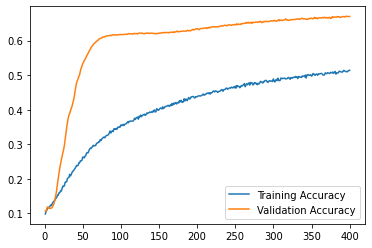

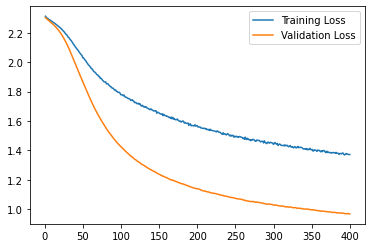

In [70]:
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(("Training Accuracy", "Validation Accuracy"))
plt.show()

plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(("Training Loss", "Validation Loss"))
plt.show()

## Visualization of Performance on the Test Set

Here is a visualization of how well our classifier can do inference.

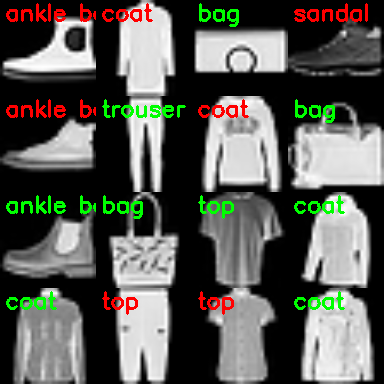

-1

In [71]:
import cv2
from imutils import build_montages
from google.colab.patches import cv2_imshow

# initialize our list of output images
images = []

labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
	# classify the clothing
	probs = model.predict(x_test[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (x_test[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (x_test[i] * 255).astype("uint8")
    # initialize the text label color as green (correct)
	color = (0, 255, 0)
 
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(y_test[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
 
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]
 
# show the output montage
cv2_imshow( montage)
cv2.waitKey(0)

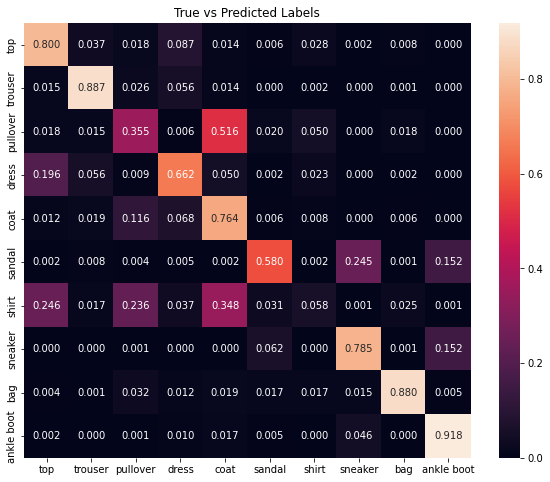

In [72]:
from seaborn import heatmap
allprobs = model.predict(x_test)
preds = allprobs.argmax(axis=1)
conmat = confusion_matrix(y_dec,preds,normalize='true')
fig,ax = plt.subplots(figsize = (10,8));
heatmap(conmat, annot=True, fmt="0.3f", ax=ax, cmap="rocket");
ax.set_xticklabels(labelNames);
ax.set_yticklabels(labelNames);
ax.set_title("True vs Predicted Labels");